# Medical VQA: Enhanced BLIP + CNN Baseline
## With Improved Training and Fair Evaluation

**Improvements over original:**
1. **BLIP**: Longer training (30 epochs), optimized hyperparameters
2. **CNN Baseline**: Question-aware model for fair comparison
3. **Evaluation**: Separate metrics for closed vs open-ended questions
4. **Visualization**: Training curves, before/after comparison

In [ ]:
# ==========================================
# Cell 1: Install Dependencies
# ==========================================
!pip install -q transformers accelerate
!pip install -q kagglehub pillow
!pip install -q nltk rouge-score
!pip install -q torchvision

import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights
from PIL import Image
from collections import Counter
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')

from transformers import BlipProcessor, BlipForQuestionAnswering

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

  Preparing metadata (setup.py) ... done
PyTorch: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-40GB


In [ ]:
# ==========================================
# Cell 2: Configuration
# ==========================================

class Config:
    # Model
    BLIP_MODEL = "Salesforce/blip-vqa-base"

    # Training - Aligned with original notebook
    IMG_SIZE = 384
    BATCH_SIZE = 16
    EPOCHS = 50  # Increased from 10 to 30
    LEARNING_RATE = 1e-5  # Aligned with original (was 2e-5)
    WEIGHT_DECAY = 0.05

    # For CNN
    CNN_EPOCHS = 50
    CNN_LR = 1e-4
    NUM_ANSWERS = 100

    # Generation
    MAX_Q_LEN = 32
    MAX_A_LEN = 10

    # Device
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Paths
    OUTPUT_DIR = "blip_enhanced_output"

config = Config()
os.makedirs(config.OUTPUT_DIR, exist_ok=True)
print(f"Device: {config.DEVICE}")
print(f"Training config: {config.EPOCHS} epochs, LR={config.LEARNING_RATE}, Batch={config.BATCH_SIZE}")

Device: cuda
Training config: 50 epochs, LR=1e-05, Batch=16


In [ ]:
# ==========================================
# Cell 3: Load and Analyze Dataset
# ==========================================
import kagglehub

print("Downloading VQA-RAD dataset...")
dataset_root = kagglehub.dataset_download(
    "shashankshekhar1205/vqa-rad-visual-question-answering-radiology"
)

# Find paths
json_path, img_dir = None, None
for root, dirs, files in os.walk(dataset_root):
    for f in files:
        if f.endswith(".json") and "VQA_RAD" in f:
            json_path = os.path.join(root, f)
    for d in dirs:
        if "image" in d.lower():
            img_dir = os.path.join(root, d)
if img_dir is None:
    img_dir = dataset_root

# Load data
with open(json_path, 'r') as f:
    raw_data = json.load(f)

# Process and categorize
all_data = []
for item in raw_data:
    img_name = item.get('image_name')
    if not img_name:
        continue
    img_path = os.path.join(img_dir, img_name)
    if os.path.exists(img_path):
        answer = str(item.get('answer', '')).strip()
        question = str(item.get('question', '')).strip()

        # Determine question type
        answer_lower = answer.lower()
        if answer_lower in ['yes', 'no']:
            q_type = 'CLOSED_YESNO'
        elif len(answer.split()) <= 3:
            q_type = 'CLOSED_SHORT'
        else:
            q_type = 'OPEN'

        all_data.append({
            'image_path': img_path,
            'question': question,
            'answer': answer,
            'q_type': q_type
        })

print(f"Total samples: {len(all_data)}")

# Analyze distribution
type_counts = Counter([d['q_type'] for d in all_data])
print(f"\nQuestion type distribution:")
for t, c in type_counts.items():
    print(f"  {t}: {c} ({100*c/len(all_data):.1f}%)")

# Split data
random.seed(42)
random.shuffle(all_data)
split = int(0.8 * len(all_data))
train_data = all_data[:split]
test_data = all_data[split:]
print(f"\nTrain: {len(train_data)}, Test: {len(test_data)}")

Using Colab cache for faster access to the 'vqa-rad-visual-question-answering-radiology' dataset.
Total samples: 2248

Question type distribution:
  CLOSED_YESNO: 1193 (53.1%)
  CLOSED_SHORT: 879 (39.1%)
  OPEN: 176 (7.8%)

Train: 1798, Test: 450


In [ ]:
# ==========================================
# Cell 4: BLIP Dataset (Aligned with original)
# ==========================================

class BLIPVQADataset(Dataset):
    """
    BLIP VQA Dataset - Aligned with official training
    """

    def __init__(self, data_list, processor, max_q_len=32, max_a_len=10):
        self.data = data_list
        self.processor = processor
        self.max_q_len = max_q_len
        self.max_a_len = max_a_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Load image
        try:
            image = Image.open(item['image_path']).convert('RGB')
        except:
            image = Image.new('RGB', (384, 384), color='black')

        question = item['question']
        answer = item['answer']

        # Process with BlipProcessor
        encoding = self.processor(
            images=image,
            text=question,
            padding='max_length',
            truncation=True,
            max_length=self.max_q_len,
            return_tensors='pt'
        )

        # Answer encoding
        answer_encoding = self.processor.tokenizer(
            answer,
            padding='max_length',
            truncation=True,
            max_length=self.max_a_len,
            return_tensors='pt'
        )

        labels = answer_encoding.input_ids.squeeze(0).clone()
        labels[labels == self.processor.tokenizer.pad_token_id] = -100

        return {
            'pixel_values': encoding['pixel_values'].squeeze(0),
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': labels,
            'decoder_input_ids': answer_encoding.input_ids.squeeze(0),
            'decoder_attention_mask': answer_encoding.attention_mask.squeeze(0),
        }

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([item['pixel_values'] for item in batch]),
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'labels': torch.stack([item['labels'] for item in batch]),
        'decoder_input_ids': torch.stack([item['decoder_input_ids'] for item in batch]),
        'decoder_attention_mask': torch.stack([item['decoder_attention_mask'] for item in batch]),
    }

print("BLIP Dataset class defined!")

BLIP Dataset class defined!


In [ ]:
# ==========================================
# Cell 5: Load BLIP Model
# ==========================================

print(f"Loading BLIP model: {config.BLIP_MODEL}")
processor = BlipProcessor.from_pretrained(config.BLIP_MODEL)
blip_model = BlipForQuestionAnswering.from_pretrained(config.BLIP_MODEL)
blip_model = blip_model.to(config.DEVICE)

print(f"Model loaded!")
print(f"Parameters: {sum(p.numel() for p in blip_model.parameters()):,}")

# Create datasets
train_dataset = BLIPVQADataset(train_data, processor, config.MAX_Q_LEN, config.MAX_A_LEN)
test_dataset = BLIPVQADataset(test_data, processor, config.MAX_Q_LEN, config.MAX_A_LEN)

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading BLIP model: Salesforce/blip-vqa-base


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Model loaded!
Parameters: 361,230,140
Train batches: 113, Test batches: 29


In [ ]:
# ==========================================
# Cell 6: Evaluate BLIP BEFORE Fine-tuning
# ==========================================

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import nltk
nltk.download('punkt', quiet=True)

def evaluate_blip(model, processor, test_data, device, max_samples=200):
    """
    Comprehensive evaluation with breakdown by question type
    """
    model.eval()

    results = {'all': [], 'CLOSED_YESNO': [], 'CLOSED_SHORT': [], 'OPEN': []}
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    smooth = SmoothingFunction().method1

    samples = test_data[:max_samples]

    for sample in tqdm(samples, desc="Evaluating BLIP"):
        try:
            image = Image.open(sample['image_path']).convert('RGB')
            question = sample['question']

            inputs = processor(images=image, text=question, return_tensors='pt').to(device)

            with torch.no_grad():
                output = model.generate(**inputs, max_length=50)
                pred = processor.decode(output[0], skip_special_tokens=True).strip().lower()

            gt = sample['answer'].lower().strip()
            q_type = sample['q_type']

            # Metrics
            exact = 1 if pred == gt else 0
            contains = 1 if gt in pred or pred in gt else 0
            bleu = sentence_bleu([gt.split()], pred.split() or [""], smoothing_function=smooth)
            rouge = scorer.score(gt, pred)['rougeL'].fmeasure

            result = {
                'question': sample['question'],
                'gt': gt,
                'pred': pred,
                'exact': exact,
                'contains': contains,
                'bleu': bleu,
                'rouge': rouge,
                'q_type': q_type
            }

            results['all'].append(result)
            results[q_type].append(result)

        except Exception as e:
            continue

    # Aggregate metrics
    metrics = {}
    for key, res_list in results.items():
        if len(res_list) > 0:
            metrics[key] = {
                'n': len(res_list),
                'exact_acc': np.mean([r['exact'] for r in res_list]) * 100,
                'contains_acc': np.mean([r['contains'] for r in res_list]) * 100,
                'bleu': np.mean([r['bleu'] for r in res_list]) * 100,
                'rouge_l': np.mean([r['rouge'] for r in res_list]) * 100
            }

    return metrics, results['all']

# Evaluate before fine-tuning
print("="*60)
print("BLIP Evaluation BEFORE Fine-tuning")
print("="*60)

baseline_metrics, baseline_results = evaluate_blip(
    blip_model, processor, test_data, config.DEVICE, max_samples=200
)

print(f"\n{'Category':<20} {'N':<6} {'Exact%':<10} {'Contains%':<12} {'BLEU':<10} {'ROUGE-L':<10}")
print("-"*70)
for key, m in baseline_metrics.items():
    print(f"{key:<20} {m['n']:<6} {m['exact_acc']:<10.2f} {m['contains_acc']:<12.2f} {m['bleu']:<10.2f} {m['rouge_l']:<10.2f}")

BLIP Evaluation BEFORE Fine-tuning


Evaluating BLIP: 100%|██████████| 200/200 [00:19<00:00, 10.06it/s]


Category             N      Exact%     Contains%    BLEU       ROUGE-L   
----------------------------------------------------------------------
all                  200    27.00      28.00        4.99       28.31     
CLOSED_YESNO         112    44.64      44.64        7.94       44.64     
CLOSED_SHORT         71     5.63       8.45         1.46       8.97      
OPEN                 17     0.00       0.00         0.34       1.47      


In [ ]:
# ==========================================
# Cell 7: BLIP Training (Aligned with original)
# ==========================================

def train_blip(model, train_loader, config, epochs):
    """
    BLIP training aligned with original notebook
    """
    model.train()

    optimizer = optim.AdamW(
        model.parameters(),
        lr=config.LEARNING_RATE,
        weight_decay=config.WEIGHT_DECAY
    )

    # Cosine annealing scheduler (same as original)
    total_steps = len(train_loader) * epochs
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=total_steps,
        eta_min=1e-6
    )

    # Mixed precision
    scaler = torch.amp.GradScaler('cuda') if config.DEVICE.type == 'cuda' else None

    history = {'epoch_loss': [], 'batch_losses': [], 'learning_rates': []}

    print(f"\n{'='*60}")
    print(f"Starting BLIP Fine-tuning")
    print(f"Epochs: {epochs}, Batch: {config.BATCH_SIZE}, LR: {config.LEARNING_RATE}")
    print(f"{'='*60}\n")

    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = 0
        model.train()

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in pbar:
            batch = {k: v.to(config.DEVICE) if isinstance(v, torch.Tensor) else v
                     for k, v in batch.items()}

            optimizer.zero_grad()

            try:
                if scaler:
                    with torch.amp.autocast('cuda'):
                        outputs = model(
                            input_ids=batch['input_ids'],
                            pixel_values=batch['pixel_values'],
                            attention_mask=batch['attention_mask'],
                            decoder_input_ids=batch['decoder_input_ids'],
                            decoder_attention_mask=batch['decoder_attention_mask'],
                            labels=batch['labels']
                        )
                        loss = outputs.loss

                    scaler.scale(loss).backward()
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    outputs = model(
                        input_ids=batch['input_ids'],
                        pixel_values=batch['pixel_values'],
                        attention_mask=batch['attention_mask'],
                        decoder_input_ids=batch['decoder_input_ids'],
                        decoder_attention_mask=batch['decoder_attention_mask'],
                        labels=batch['labels']
                    )
                    loss = outputs.loss
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()

                scheduler.step()

                epoch_loss += loss.item()
                num_batches += 1
                history['batch_losses'].append(loss.item())
                history['learning_rates'].append(scheduler.get_last_lr()[0])

                pbar.set_postfix({'loss': f"{loss.item():.4f}", 'lr': f"{scheduler.get_last_lr()[0]:.2e}"})

            except Exception as e:
                print(f"Batch error: {e}")
                continue

        avg_loss = epoch_loss / max(num_batches, 1)
        history['epoch_loss'].append(avg_loss)
        print(f"Epoch {epoch+1} - Average Loss: {avg_loss:.4f}")

    return model, history

# Train
blip_model, train_history = train_blip(blip_model, train_loader, config, epochs=config.EPOCHS)

# Save model
blip_model.save_pretrained(f"{config.OUTPUT_DIR}/blip_finetuned")
processor.save_pretrained(f"{config.OUTPUT_DIR}/blip_finetuned")
print(f"\nModel saved to {config.OUTPUT_DIR}/blip_finetuned")


Starting BLIP Fine-tuning
Epochs: 50, Batch: 16, LR: 1e-05



Epoch 1/50: 100%|██████████| 113/113 [01:05<00:00,  1.73it/s, loss=3.5653, lr=9.99e-06]


Epoch 1 - Average Loss: 3.2657


Epoch 2/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=1.6096, lr=9.96e-06]


Epoch 2 - Average Loss: 2.1591


Epoch 3/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.3793, lr=9.92e-06]


Epoch 3 - Average Loss: 1.5340


Epoch 4/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.1315, lr=9.86e-06]


Epoch 4 - Average Loss: 1.0877


Epoch 5/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.2397, lr=9.78e-06]


Epoch 5 - Average Loss: 0.7938


Epoch 6/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.9219, lr=9.68e-06]


Epoch 6 - Average Loss: 0.6122


Epoch 7/50: 100%|██████████| 113/113 [01:04<00:00,  1.76it/s, loss=0.0037, lr=9.57e-06]


Epoch 7 - Average Loss: 0.4660


Epoch 8/50: 100%|██████████| 113/113 [01:03<00:00,  1.77it/s, loss=0.0159, lr=9.44e-06]


Epoch 8 - Average Loss: 0.3701


Epoch 9/50: 100%|██████████| 113/113 [01:03<00:00,  1.79it/s, loss=0.1257, lr=9.30e-06]


Epoch 9 - Average Loss: 0.3092


Epoch 10/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.0251, lr=9.14e-06]


Epoch 10 - Average Loss: 0.2626


Epoch 11/50: 100%|██████████| 113/113 [01:03<00:00,  1.77it/s, loss=0.2047, lr=8.97e-06]


Epoch 11 - Average Loss: 0.2286


Epoch 12/50: 100%|██████████| 113/113 [01:03<00:00,  1.77it/s, loss=0.0019, lr=8.78e-06]


Epoch 12 - Average Loss: 0.2010


Epoch 13/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.2647, lr=8.58e-06]


Epoch 13 - Average Loss: 0.1780


Epoch 14/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.0786, lr=8.37e-06]


Epoch 14 - Average Loss: 0.1634


Epoch 15/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.1965, lr=8.15e-06]


Epoch 15 - Average Loss: 0.1487


Epoch 16/50: 100%|██████████| 113/113 [01:03<00:00,  1.77it/s, loss=0.1777, lr=7.91e-06]


Epoch 16 - Average Loss: 0.1456


Epoch 17/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.5992, lr=7.67e-06]


Epoch 17 - Average Loss: 0.1368


Epoch 18/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.0048, lr=7.42e-06]


Epoch 18 - Average Loss: 0.1181


Epoch 19/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.0003, lr=7.16e-06]


Epoch 19 - Average Loss: 0.1091


Epoch 20/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.2821, lr=6.89e-06]


Epoch 20 - Average Loss: 0.1039


Epoch 21/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.2453, lr=6.62e-06]


Epoch 21 - Average Loss: 0.0993


Epoch 22/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.1537, lr=6.34e-06]


Epoch 22 - Average Loss: 0.0917


Epoch 23/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.0006, lr=6.06e-06]


Epoch 23 - Average Loss: 0.0868


Epoch 24/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.0004, lr=5.78e-06]


Epoch 24 - Average Loss: 0.0819


Epoch 25/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.0643, lr=5.50e-06]


Epoch 25 - Average Loss: 0.0789


Epoch 26/50: 100%|██████████| 113/113 [01:03<00:00,  1.77it/s, loss=0.0429, lr=5.22e-06]


Epoch 26 - Average Loss: 0.0732


Epoch 27/50: 100%|██████████| 113/113 [01:03<00:00,  1.77it/s, loss=0.0013, lr=4.94e-06]


Epoch 27 - Average Loss: 0.0709


Epoch 28/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.0001, lr=4.66e-06]


Epoch 28 - Average Loss: 0.0670


Epoch 29/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.0002, lr=4.38e-06]


Epoch 29 - Average Loss: 0.0646


Epoch 30/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.0624, lr=4.11e-06]


Epoch 30 - Average Loss: 0.0618


Epoch 31/50: 100%|██████████| 113/113 [01:03<00:00,  1.77it/s, loss=0.0758, lr=3.84e-06]


Epoch 31 - Average Loss: 0.0590


Epoch 32/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.0067, lr=3.58e-06]


Epoch 32 - Average Loss: 0.0566


Epoch 33/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.1122, lr=3.33e-06]


Epoch 33 - Average Loss: 0.0545


Epoch 34/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.0054, lr=3.09e-06]


Epoch 34 - Average Loss: 0.0525


Epoch 35/50: 100%|██████████| 113/113 [01:03<00:00,  1.79it/s, loss=0.0001, lr=2.85e-06]


Epoch 35 - Average Loss: 0.0500


Epoch 36/50: 100%|██████████| 113/113 [01:04<00:00,  1.75it/s, loss=0.0005, lr=2.63e-06]


Epoch 36 - Average Loss: 0.0487


Epoch 37/50: 100%|██████████| 113/113 [01:03<00:00,  1.77it/s, loss=0.0002, lr=2.42e-06]


Epoch 37 - Average Loss: 0.0462


Epoch 38/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.0001, lr=2.22e-06]


Epoch 38 - Average Loss: 0.0458


Epoch 39/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.0166, lr=2.03e-06]


Epoch 39 - Average Loss: 0.0436


Epoch 40/50: 100%|██████████| 113/113 [01:04<00:00,  1.76it/s, loss=0.0000, lr=1.86e-06]


Epoch 40 - Average Loss: 0.0443


Epoch 41/50: 100%|██████████| 113/113 [01:03<00:00,  1.77it/s, loss=0.0373, lr=1.70e-06]


Epoch 41 - Average Loss: 0.0440


Epoch 42/50: 100%|██████████| 113/113 [01:03<00:00,  1.77it/s, loss=0.0480, lr=1.56e-06]


Epoch 42 - Average Loss: 0.0422


Epoch 43/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.0001, lr=1.43e-06]


Epoch 43 - Average Loss: 0.0418


Epoch 44/50: 100%|██████████| 113/113 [01:03<00:00,  1.77it/s, loss=0.0000, lr=1.32e-06]


Epoch 44 - Average Loss: 0.0415


Epoch 45/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.0152, lr=1.22e-06]


Epoch 45 - Average Loss: 0.0404


Epoch 46/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.0006, lr=1.14e-06]


Epoch 46 - Average Loss: 0.0393


Epoch 47/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.0540, lr=1.08e-06]


Epoch 47 - Average Loss: 0.0383


Epoch 48/50: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s, loss=0.0005, lr=1.04e-06]


Epoch 48 - Average Loss: 0.0387


Epoch 49/50: 100%|██████████| 113/113 [01:02<00:00,  1.80it/s, loss=0.0002, lr=1.01e-06]


Epoch 49 - Average Loss: 0.0380


Epoch 50/50: 100%|██████████| 113/113 [01:03<00:00,  1.77it/s, loss=0.0001, lr=1.00e-06]


Epoch 50 - Average Loss: 0.0373

Model saved to blip_enhanced_output/blip_finetuned


In [ ]:
# ==========================================
# Cell 8: Evaluate BLIP AFTER Fine-tuning
# ==========================================

print("="*60)
print("BLIP Evaluation AFTER Fine-tuning")
print("="*60)

finetuned_metrics, finetuned_results = evaluate_blip(
    blip_model, processor, test_data, config.DEVICE, max_samples=200
)

print(f"\n{'Category':<20} {'N':<6} {'Exact%':<10} {'Contains%':<12} {'BLEU':<10} {'ROUGE-L':<10}")
print("-"*70)
for key, m in finetuned_metrics.items():
    print(f"{key:<20} {m['n']:<6} {m['exact_acc']:<10.2f} {m['contains_acc']:<12.2f} {m['bleu']:<10.2f} {m['rouge_l']:<10.2f}")

# Comparison
print("\n" + "="*70)
print("COMPARISON: Before vs After Fine-tuning (Overall)")
print("="*70)
print(f"{'Metric':<20} {'Before':<15} {'After':<15} {'Change':<15}")
print("-"*70)

for metric in ['exact_acc', 'contains_acc', 'bleu', 'rouge_l']:
    before = baseline_metrics['all'][metric]
    after = finetuned_metrics['all'][metric]
    change = after - before
    print(f"{metric:<20} {before:<15.2f} {after:<15.2f} {'+' if change >= 0 else ''}{change:<15.2f}")

BLIP Evaluation AFTER Fine-tuning


Evaluating BLIP: 100%|██████████| 200/200 [00:20<00:00,  9.60it/s]


Category             N      Exact%     Contains%    BLEU       ROUGE-L   
----------------------------------------------------------------------
all                  200    64.00      66.50        16.19      68.92     
CLOSED_YESNO         112    75.89      75.89        13.50      75.89     
CLOSED_SHORT         71     53.52      59.15        14.54      61.14     
OPEN                 17     29.41      35.29        40.89      55.48     

COMPARISON: Before vs After Fine-tuning (Overall)
Metric               Before          After           Change         
----------------------------------------------------------------------
exact_acc            27.00           64.00           +37.00          
contains_acc         28.00           66.50           +38.50          
bleu                 4.99            16.19           +11.20          
rouge_l              28.31           68.92           +40.61          


In [ ]:
# ==========================================
# Cell 9: CNN Baseline Model
# ==========================================

class CNNVQAModel(nn.Module):
    """
    CNN Baseline with question encoding
    - ResNet50 for image features
    - Simple text encoder for questions
    - Classification head

    Note: This model can ONLY answer closed-ended questions
    where answers are in the predefined vocabulary.
    """

    def __init__(self, num_answers, hidden_dim=512):
        super().__init__()

        # Image encoder
        resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.img_encoder = nn.Sequential(*list(resnet.children())[:-1])
        self.img_proj = nn.Linear(2048, hidden_dim)

        # Question encoder
        self.vocab_size = 5000
        self.word_embed = nn.Embedding(self.vocab_size, 256)
        self.q_proj = nn.Linear(256, hidden_dim)

        # Fusion
        self.fusion = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_answers)
        )

        self.word2idx = {}
        self.idx = 1

    def tokenize(self, text, max_len=20):
        words = text.lower().split()[:max_len]
        ids = []
        for w in words:
            if w not in self.word2idx:
                if self.idx < self.vocab_size:
                    self.word2idx[w] = self.idx
                    self.idx += 1
                else:
                    continue
            ids.append(self.word2idx[w])
        ids = ids + [0] * (max_len - len(ids))
        return torch.tensor(ids[:max_len])

    def forward(self, images, question_ids):
        img_feat = self.img_encoder(images).squeeze(-1).squeeze(-1)
        img_feat = self.img_proj(img_feat)

        q_embed = self.word_embed(question_ids)
        q_feat = q_embed.mean(dim=1)
        q_feat = self.q_proj(q_feat)

        combined = torch.cat([img_feat, q_feat], dim=-1)
        logits = self.fusion(combined)

        return logits

# Build answer vocabulary
answer_counts = Counter([d['answer'].lower() for d in train_data])
top_answers = answer_counts.most_common(config.NUM_ANSWERS)
ans2idx = {ans: i for i, (ans, _) in enumerate(top_answers)}
idx2ans = {i: ans for ans, i in ans2idx.items()}

print(f"Answer vocabulary size: {len(ans2idx)}")
print(f"Top 10 answers: {[a for a, _ in top_answers[:10]]}")

Answer vocabulary size: 100
Top 10 answers: ['no', 'yes', 'axial', 'right', 'left', 'pa', 'brain', 'ct', 'fat', 'mri']


In [ ]:
# ==========================================
# Cell 10: CNN Dataset and Training
# ==========================================

class CNNVQADataset(Dataset):
    def __init__(self, data_list, ans2idx, cnn_model, transform=None):
        self.data = [d for d in data_list if d['answer'].lower() in ans2idx]
        self.ans2idx = ans2idx
        self.model = cnn_model
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        print(f"CNN Dataset: {len(self.data)}/{len(data_list)} samples (answers in vocab)")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        try:
            image = Image.open(item['image_path']).convert('RGB')
            image = self.transform(image)
        except:
            image = torch.zeros(3, 224, 224)

        q_ids = self.model.tokenize(item['question'])
        label = self.ans2idx[item['answer'].lower()]

        return image, q_ids, torch.tensor(label)

# Create CNN model and datasets
cnn_model = CNNVQAModel(num_answers=len(ans2idx)).to(config.DEVICE)

cnn_train_dataset = CNNVQADataset(train_data, ans2idx, cnn_model)
cnn_test_dataset = CNNVQADataset(test_data, ans2idx, cnn_model)

cnn_train_loader = DataLoader(cnn_train_dataset, batch_size=16, shuffle=True)
cnn_test_loader = DataLoader(cnn_test_dataset, batch_size=16, shuffle=False)

# Train CNN
print(f"\n{'='*60}")
print("Training CNN Baseline")
print(f"{'='*60}")

cnn_optimizer = optim.AdamW(cnn_model.parameters(), lr=config.CNN_LR)
cnn_criterion = nn.CrossEntropyLoss()
cnn_scheduler = optim.lr_scheduler.StepLR(cnn_optimizer, step_size=10, gamma=0.5)

cnn_history = {'train_loss': [], 'train_acc': [], 'test_acc': []}

for epoch in range(config.CNN_EPOCHS):
    cnn_model.train()
    total_loss, correct, total = 0, 0, 0

    for images, q_ids, labels in tqdm(cnn_train_loader, desc=f"CNN Epoch {epoch+1}"):
        images = images.to(config.DEVICE)
        q_ids = q_ids.to(config.DEVICE)
        labels = labels.to(config.DEVICE)

        cnn_optimizer.zero_grad()
        logits = cnn_model(images, q_ids)
        loss = cnn_criterion(logits, labels)
        loss.backward()
        cnn_optimizer.step()

        total_loss += loss.item()
        _, preds = logits.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    cnn_scheduler.step()
    train_acc = 100 * correct / total
    cnn_history['train_loss'].append(total_loss / len(cnn_train_loader))
    cnn_history['train_acc'].append(train_acc)

    # Test
    cnn_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, q_ids, labels in cnn_test_loader:
            images = images.to(config.DEVICE)
            q_ids = q_ids.to(config.DEVICE)
            labels = labels.to(config.DEVICE)

            logits = cnn_model(images, q_ids)
            _, preds = logits.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_acc = 100 * correct / total
    cnn_history['test_acc'].append(test_acc)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}%, Test Acc={test_acc:.2f}%")

print(f"\nCNN Final Test Accuracy: {cnn_history['test_acc'][-1]:.2f}%")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 147MB/s]


CNN Dataset: 1357/1798 samples (answers in vocab)
CNN Dataset: 310/450 samples (answers in vocab)

Training CNN Baseline


CNN Epoch 5: 100%|██████████| 85/85 [00:14<00:00,  5.91it/s]


Epoch 5: Train Acc=49.59%, Test Acc=55.16%


CNN Epoch 10: 100%|██████████| 85/85 [00:14<00:00,  6.00it/s]


Epoch 10: Train Acc=56.74%, Test Acc=60.65%


CNN Epoch 15: 100%|██████████| 85/85 [00:14<00:00,  5.96it/s]


Epoch 15: Train Acc=66.62%, Test Acc=61.29%


CNN Epoch 20: 100%|██████████| 85/85 [00:14<00:00,  6.01it/s]


Epoch 20: Train Acc=71.04%, Test Acc=61.94%


CNN Epoch 25: 100%|██████████| 85/85 [00:14<00:00,  6.03it/s]


Epoch 25: Train Acc=74.58%, Test Acc=62.58%


CNN Epoch 30: 100%|██████████| 85/85 [00:14<00:00,  5.91it/s]


Epoch 30: Train Acc=76.79%, Test Acc=63.23%


CNN Epoch 35: 100%|██████████| 85/85 [00:14<00:00,  5.96it/s]


Epoch 35: Train Acc=78.11%, Test Acc=64.84%


CNN Epoch 40: 100%|██████████| 85/85 [00:14<00:00,  5.97it/s]


Epoch 40: Train Acc=78.56%, Test Acc=63.23%


CNN Epoch 45: 100%|██████████| 85/85 [00:14<00:00,  6.00it/s]


Epoch 45: Train Acc=80.47%, Test Acc=64.19%


CNN Epoch 50: 100%|██████████| 85/85 [00:14<00:00,  5.87it/s]


Epoch 50: Train Acc=79.07%, Test Acc=65.16%

CNN Final Test Accuracy: 65.16%


In [ ]:
# ==========================================
# Cell 11: Fair Comparison - CNN vs BLIP
# ==========================================

print("="*70)
print("FAIR COMPARISON: CNN Baseline vs BLIP (Fine-tuned)")
print("="*70)

# Evaluate CNN on test data
cnn_model.eval()
cnn_results = []

for item in tqdm(test_data[:200], desc="Evaluating CNN"):
    gt = item['answer'].lower()
    if gt not in ans2idx:
        continue

    try:
        image = Image.open(item['image_path']).convert('RGB')
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        image_t = transform(image).unsqueeze(0).to(config.DEVICE)
        q_ids = cnn_model.tokenize(item['question']).unsqueeze(0).to(config.DEVICE)

        with torch.no_grad():
            logits = cnn_model(image_t, q_ids)
            pred_idx = logits.argmax(1).item()
            pred = idx2ans[pred_idx]

        cnn_results.append({
            'gt': gt,
            'pred': pred,
            'correct': 1 if pred == gt else 0,
            'q_type': item['q_type']
        })
    except:
        continue

# Get BLIP results on same questions
blip_on_cnn_subset = [r for r in finetuned_results if r['gt'] in ans2idx][:len(cnn_results)]

print(f"\nComparison on {len(cnn_results)} closed-ended questions:")
print("-"*70)

cnn_acc = np.mean([r['correct'] for r in cnn_results]) * 100
blip_acc_exact = np.mean([1 if r['pred'] == r['gt'] else 0 for r in blip_on_cnn_subset]) * 100 if blip_on_cnn_subset else 0
blip_acc_contains = np.mean([1 if r['gt'] in r['pred'] or r['pred'] in r['gt'] else 0 for r in blip_on_cnn_subset]) * 100 if blip_on_cnn_subset else 0

print(f"{'Model':<25} {'Exact Match %':<20} {'Contains Match %':<20}")
print(f"{'CNN Baseline':<25} {cnn_acc:<20.2f} {'N/A (classification)':<20}")
print(f"{'BLIP (Fine-tuned)':<25} {blip_acc_exact:<20.2f} {blip_acc_contains:<20.2f}")

# By question type
print(f"\nBreakdown by question type:")
print("-"*70)
for q_type in ['CLOSED_YESNO', 'CLOSED_SHORT']:
    cnn_type = [r for r in cnn_results if r['q_type'] == q_type]
    blip_type = [r for r in blip_on_cnn_subset if r['q_type'] == q_type]

    if cnn_type:
        cnn_type_acc = np.mean([r['correct'] for r in cnn_type]) * 100
        blip_type_acc = np.mean([1 if r['pred'] == r['gt'] else 0 for r in blip_type]) * 100 if blip_type else 0
        print(f"{q_type}: CNN={cnn_type_acc:.2f}%, BLIP={blip_type_acc:.2f}%")

FAIR COMPARISON: CNN Baseline vs BLIP (Fine-tuned)


Evaluating CNN: 100%|██████████| 200/200 [00:02<00:00, 80.36it/s]


Comparison on 143 closed-ended questions:
----------------------------------------------------------------------
Model                     Exact Match %        Contains Match %    
CNN Baseline              67.83                N/A (classification)
BLIP (Fine-tuned)         76.92                77.62               

Breakdown by question type:
----------------------------------------------------------------------
CLOSED_YESNO: CNN=70.54%, BLIP=75.89%
CLOSED_SHORT: CNN=53.57%, BLIP=82.14%


In [ ]:
# ==========================================
# Cell 12: Visualization & Plots
# ==========================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. BLIP Training Loss
if train_history['batch_losses']:
    window = min(50, len(train_history['batch_losses']) // 10 + 1)
    smoothed = np.convolve(train_history['batch_losses'], np.ones(window)/window, mode='valid')
    axes[0, 0].plot(smoothed, 'b-', linewidth=2)
    axes[0, 0].set_xlabel('Step')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('BLIP Training Loss (Smoothed)')
    axes[0, 0].grid(True, alpha=0.3)

# 2. BLIP Epoch Loss
epochs_range = range(1, len(train_history['epoch_loss']) + 1)
axes[0, 1].plot(epochs_range, train_history['epoch_loss'], 'b-o', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('BLIP Training Loss per Epoch')
axes[0, 1].grid(True, alpha=0.3)

# 3. BLIP Before vs After Fine-tuning
metrics_to_plot = ['exact_acc', 'contains_acc', 'bleu', 'rouge_l']
x = np.arange(len(metrics_to_plot))
width = 0.35
before_vals = [baseline_metrics['all'][m] for m in metrics_to_plot]
after_vals = [finetuned_metrics['all'][m] for m in metrics_to_plot]

bars1 = axes[1, 0].bar(x - width/2, before_vals, width, label='Before FT', color='#ff6b6b')
bars2 = axes[1, 0].bar(x + width/2, after_vals, width, label='After FT', color='#4ecdc4')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(['Exact', 'Contains', 'BLEU', 'ROUGE-L'])
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('BLIP: Before vs After Fine-tuning')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. CNN vs BLIP Comparison
models = ['CNN Baseline', 'BLIP (FT)']
accs = [cnn_acc, finetuned_metrics['all']['contains_acc']]
colors = ['#ff6b6b', '#4ecdc4']
bars = axes[1, 1].bar(models, accs, color=colors)
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].set_title('Model Comparison')
axes[1, 1].bar_label(bars, fmt='%.1f%%')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Medical VQA: BLIP Enhanced Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{config.OUTPUT_DIR}/results_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Visualization saved to {config.OUTPUT_DIR}/results_visualization.png")

Visualization saved to blip_enhanced_output/results_visualization.png


In [ ]:
# ==========================================
# Cell 13: Sample Outputs
# ==========================================

print("="*70)
print("SAMPLE OUTPUTS")
print("="*70)

# Show examples from different question types
for q_type in ['CLOSED_YESNO', 'CLOSED_SHORT', 'OPEN']:
    type_results = [r for r in finetuned_results if r['q_type'] == q_type][:3]
    if type_results:
        print(f"\n[{q_type}]")
        for r in type_results:
            match = 'OK' if r['pred'] == r['gt'] else 'X'
            print(f"  Q: {r['question']}")
            print(f"  GT: {r['gt']}")
            print(f"  BLIP: {r['pred']} [{match}]")
            # CNN prediction if available
            if r['gt'] in ans2idx:
                cnn_match = [c for c in cnn_results if c['gt'] == r['gt']]
                if cnn_match:
                    cnn_ok = 'OK' if cnn_match[0]['pred'] == r['gt'] else 'X'
                    print(f"  CNN: {cnn_match[0]['pred']} [{cnn_ok}]")
            print()

SAMPLE OUTPUTS

[CLOSED_YESNO]
  Q: Is this a hepatic mass?
  GT: yes
  BLIP: yes [OK]
  CNN: yes [OK]

  Q: Is the mass compressing the mid brain on this section?
  GT: yes
  BLIP: no [X]
  CNN: yes [OK]

  Q: Does this image show a pleural effusion?
  GT: no
  BLIP: no [OK]
  CNN: no [OK]


[CLOSED_SHORT]
  Q: Where is the spleen located?
  GT: on the left
  BLIP: posterior lung seen in the image section [X]

  Q: Which side is more clearly visualized?
  GT: left
  BLIP: left [OK]
  CNN: left [OK]

  Q: Where is the mass?
  GT: suprasellar cistern
  BLIP: right frontal lobe [X]


[OPEN]
  Q: What is evinced by this brain image?
  GT: loss of normal gray-white matter junction
  BLIP: hypoxic ischemic injury [X]

  Q: Where does the catheter tip extend into?
  GT: right superior cavoatrial junction
  BLIP: right superior cavoatrial junction [OK]

  Q: What is the pathology?
  GT: right sided pleural effusion
  BLIP: right sided pleural effusion [OK]
  CNN: right sided pleural effusion 

In [ ]:
# ==========================================
# Cell 14: Save Results
# ==========================================

all_results = {
    "blip": {
        "model": config.BLIP_MODEL,
        "epochs": config.EPOCHS,
        "learning_rate": config.LEARNING_RATE,
        "baseline_metrics": baseline_metrics,
        "finetuned_metrics": finetuned_metrics,
        "improvement": {
            "exact_acc": finetuned_metrics['all']['exact_acc'] - baseline_metrics['all']['exact_acc'],
            "contains_acc": finetuned_metrics['all']['contains_acc'] - baseline_metrics['all']['contains_acc'],
            "bleu": finetuned_metrics['all']['bleu'] - baseline_metrics['all']['bleu'],
            "rouge_l": finetuned_metrics['all']['rouge_l'] - baseline_metrics['all']['rouge_l']
        }
    },
    "cnn": {
        "final_train_acc": cnn_history['train_acc'][-1],
        "final_test_acc": cnn_history['test_acc'][-1],
        "vocab_size": len(ans2idx)
    },
    "comparison": {
        "cnn_accuracy": cnn_acc,
        "blip_exact_accuracy": blip_acc_exact,
        "blip_contains_accuracy": blip_acc_contains,
        "blip_advantage_exact": blip_acc_exact - cnn_acc,
        "blip_advantage_contains": blip_acc_contains - cnn_acc
    }
}

with open(f'{config.OUTPUT_DIR}/all_results.json', 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"Results saved to {config.OUTPUT_DIR}/all_results.json")

# Final Summary
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"\nBLIP Fine-tuned ({config.EPOCHS} epochs):")
print(f"  - Exact Accuracy: {finetuned_metrics['all']['exact_acc']:.2f}%")
print(f"  - Contains Accuracy: {finetuned_metrics['all']['contains_acc']:.2f}%")
print(f"  - BLEU: {finetuned_metrics['all']['bleu']:.2f}")
print(f"  - ROUGE-L: {finetuned_metrics['all']['rouge_l']:.2f}")
print(f"  - Improvement from baseline: +{finetuned_metrics['all']['exact_acc'] - baseline_metrics['all']['exact_acc']:.2f}%")
print(f"\nCNN Baseline ({config.CNN_EPOCHS} epochs):")
print(f"  - Accuracy on closed questions: {cnn_acc:.2f}%")
print(f"  - Limitation: Cannot answer open-ended questions")
print(f"\nBLIP Advantage: +{blip_acc_exact - cnn_acc:.2f}% (exact match)")
print(f"               +{blip_acc_contains - cnn_acc:.2f}% (contains match)")

Results saved to blip_enhanced_output/all_results.json

FINAL SUMMARY

BLIP Fine-tuned (50 epochs):
  - Exact Accuracy: 64.00%
  - Contains Accuracy: 66.50%
  - BLEU: 16.19
  - ROUGE-L: 68.92
  - Improvement from baseline: +37.00%

CNN Baseline (50 epochs):
  - Accuracy on closed questions: 67.83%
  - Limitation: Cannot answer open-ended questions

BLIP Advantage: +9.09% (exact match)
               +9.79% (contains match)


In [ ]:
# ==========================================
# Cell 14-B: Report Figures (Run after training)
# ==========================================

import seaborn as sns
from collections import Counter

# Create output directory
os.makedirs(f"{config.OUTPUT_DIR}/report_figures", exist_ok=True)

# ========== Figure 1: Training Curves ==========
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# BLIP Training Loss (smoothed)
if train_history['batch_losses']:
    window = min(50, len(train_history['batch_losses']) // 10 + 1)
    smoothed = np.convolve(train_history['batch_losses'], np.ones(window)/window, mode='valid')
    axes[0, 0].plot(smoothed, 'b-', linewidth=1.5, alpha=0.8)
    axes[0, 0].set_xlabel('Training Step', fontsize=11)
    axes[0, 0].set_ylabel('Loss', fontsize=11)
    axes[0, 0].set_title('BLIP Training Loss (Smoothed)', fontsize=12, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

# BLIP Epoch Loss
epochs_range = range(1, len(train_history['epoch_loss']) + 1)
axes[0, 1].plot(epochs_range, train_history['epoch_loss'], 'b-o', linewidth=2, markersize=4)
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Average Loss', fontsize=11)
axes[0, 1].set_title('BLIP Loss per Epoch', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# CNN Training Curves
cnn_epochs = range(1, len(cnn_history['train_acc']) + 1)
axes[1, 0].plot(cnn_epochs, cnn_history['train_acc'], 'b-', label='Train Acc', linewidth=2)
axes[1, 0].plot(cnn_epochs, cnn_history['test_acc'], 'r-', label='Test Acc', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('Accuracy (%)', fontsize=11)
axes[1, 0].set_title('CNN Baseline Training', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Learning Rate Schedule
if train_history['learning_rates']:
    axes[1, 1].plot(train_history['learning_rates'], 'g-', linewidth=1.5)
    axes[1, 1].set_xlabel('Training Step', fontsize=11)
    axes[1, 1].set_ylabel('Learning Rate', fontsize=11)
    axes[1, 1].set_title('BLIP Learning Rate (Cosine Annealing)', fontsize=12, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Training Curves', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{config.OUTPUT_DIR}/report_figures/fig1_training_curves.png', dpi=200, bbox_inches='tight')
plt.show()

# ========== Figure 2: Before vs After Fine-tuning ==========
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart comparison
metrics_names = ['Exact Match', 'Contains Match', 'BLEU', 'ROUGE-L']
metrics_keys = ['exact_acc', 'contains_acc', 'bleu', 'rouge_l']
x = np.arange(len(metrics_names))
width = 0.35

before_vals = [baseline_metrics['all'][m] for m in metrics_keys]
after_vals = [finetuned_metrics['all'][m] for m in metrics_keys]

bars1 = axes[0].bar(x - width/2, before_vals, width, label='Before Fine-tuning', color='#e74c3c', alpha=0.8)
bars2 = axes[0].bar(x + width/2, after_vals, width, label='After Fine-tuning', color='#27ae60', alpha=0.8)

axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_names, fontsize=11)
axes[0].set_ylabel('Score (%)', fontsize=11)
axes[0].set_title('BLIP: Before vs After Fine-tuning', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, val in zip(bars1, before_vals):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.1f}', ha='center', fontsize=9)
for bar, val in zip(bars2, after_vals):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.1f}', ha='center', fontsize=9)

# Improvement chart
improvements = [after - before for before, after in zip(before_vals, after_vals)]
colors = ['#27ae60' if imp > 0 else '#e74c3c' for imp in improvements]
bars3 = axes[1].bar(metrics_names, improvements, color=colors, alpha=0.8)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_ylabel('Improvement (%)', fontsize=11)
axes[1].set_title('Fine-tuning Improvement', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

for bar, imp in zip(bars3, improvements):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'+{imp:.1f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{config.OUTPUT_DIR}/report_figures/fig2_finetuning_comparison.png', dpi=200, bbox_inches='tight')
plt.show()

# ========== Figure 3: CNN vs BLIP Comparison ==========
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall comparison
models = ['CNN\nBaseline', 'BLIP\n(Fine-tuned)']
# Use the fair comparison metrics (closed-ended only)
cnn_fair = cnn_acc  # From Cell 11
blip_fair = blip_acc_exact if 'blip_acc_exact' in dir() else finetuned_metrics['all']['exact_acc']

accs = [cnn_fair, blip_fair]
colors = ['#3498db', '#e74c3c']
bars = axes[0].bar(models, accs, color=colors, alpha=0.8, width=0.5)
axes[0].set_ylabel('Accuracy (%)', fontsize=11)
axes[0].set_title('Model Comparison\n(Closed-ended Questions)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim(0, 100)

for bar, acc in zip(bars, accs):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{acc:.1f}%', ha='center', fontsize=12, fontweight='bold')

# By question type
q_types = ['CLOSED_YESNO', 'CLOSED_SHORT']
q_type_labels = ['Yes/No\nQuestions', 'Short Answer\nQuestions']
x = np.arange(len(q_types))
width = 0.35

cnn_by_type = []
blip_by_type = []
for qt in q_types:
    cnn_t = [r for r in cnn_results if r['q_type'] == qt]
    blip_t = [r for r in finetuned_results if r['q_type'] == qt]
    cnn_by_type.append(np.mean([r['correct'] for r in cnn_t]) * 100 if cnn_t else 0)
    blip_by_type.append(np.mean([r['exact'] for r in blip_t]) * 100 if blip_t else 0)

bars1 = axes[1].bar(x - width/2, cnn_by_type, width, label='CNN', color='#3498db', alpha=0.8)
bars2 = axes[1].bar(x + width/2, blip_by_type, width, label='BLIP', color='#e74c3c', alpha=0.8)

axes[1].set_xticks(x)
axes[1].set_xticklabels(q_type_labels, fontsize=11)
axes[1].set_ylabel('Accuracy (%)', fontsize=11)
axes[1].set_title('Performance by Question Type', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim(0, 100)

plt.tight_layout()
plt.savefig(f'{config.OUTPUT_DIR}/report_figures/fig3_model_comparison.png', dpi=200, bbox_inches='tight')
plt.show()

# ========== Figure 4: Question Type Distribution ==========
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Dataset distribution
type_counts = Counter([d['q_type'] for d in all_data])
labels = ['Yes/No', 'Short Answer', 'Open-ended']
sizes = [type_counts['CLOSED_YESNO'], type_counts['CLOSED_SHORT'], type_counts['OPEN']]
colors = ['#3498db', '#2ecc71', '#e74c3c']
explode = (0.02, 0.02, 0.02)

axes[0].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=False, startangle=90, textprops={'fontsize': 11})
axes[0].set_title('Question Type Distribution\nin VQA-RAD Dataset', fontsize=12, fontweight='bold')

# BLIP performance by type
q_type_names = ['Yes/No', 'Short Answer', 'Open-ended']
blip_accs = [
    finetuned_metrics.get('CLOSED_YESNO', {}).get('exact_acc', 0),
    finetuned_metrics.get('CLOSED_SHORT', {}).get('exact_acc', 0),
    finetuned_metrics.get('OPEN', {}).get('exact_acc', 0)
]

bars = axes[1].bar(q_type_names, blip_accs, color=colors, alpha=0.8)
axes[1].set_ylabel('Accuracy (%)', fontsize=11)
axes[1].set_title('BLIP Performance by Question Type', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim(0, 100)

for bar, acc in zip(bars, blip_accs):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{acc:.1f}%', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{config.OUTPUT_DIR}/report_figures/fig4_question_types.png', dpi=200, bbox_inches='tight')
plt.show()

# ========== Figure 5: Summary Table ==========
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('off')

# Create summary table
table_data = [
    ['Metric', 'CNN Baseline', 'BLIP (Before FT)', 'BLIP (After FT)', 'Improvement'],
    ['Exact Match (%)', f'{cnn_acc:.2f}', f'{baseline_metrics["all"]["exact_acc"]:.2f}', f'{finetuned_metrics["all"]["exact_acc"]:.2f}', f'+{finetuned_metrics["all"]["exact_acc"] - baseline_metrics["all"]["exact_acc"]:.2f}'],
    ['Contains Match (%)', 'N/A', f'{baseline_metrics["all"]["contains_acc"]:.2f}', f'{finetuned_metrics["all"]["contains_acc"]:.2f}', f'+{finetuned_metrics["all"]["contains_acc"] - baseline_metrics["all"]["contains_acc"]:.2f}'],
    ['BLEU', 'N/A', f'{baseline_metrics["all"]["bleu"]:.2f}', f'{finetuned_metrics["all"]["bleu"]:.2f}', f'+{finetuned_metrics["all"]["bleu"] - baseline_metrics["all"]["bleu"]:.2f}'],
    ['ROUGE-L', 'N/A', f'{baseline_metrics["all"]["rouge_l"]:.2f}', f'{finetuned_metrics["all"]["rouge_l"]:.2f}', f'+{finetuned_metrics["all"]["rouge_l"] - baseline_metrics["all"]["rouge_l"]:.2f}'],
    ['Yes/No Questions (%)', f'{cnn_by_type[0]:.2f}' if cnn_by_type else 'N/A', '-', f'{blip_by_type[0]:.2f}' if blip_by_type else '-', '-'],
    ['Short Answer (%)', f'{cnn_by_type[1]:.2f}' if len(cnn_by_type) > 1 else 'N/A', '-', f'{blip_by_type[1]:.2f}' if len(blip_by_type) > 1 else '-', '-'],
    ['Open-ended (%)', 'N/A', '-', f'{finetuned_metrics.get("OPEN", {}).get("exact_acc", 0):.2f}', '-'],
]

table = ax.table(cellText=table_data, loc='center', cellLoc='center',
                 colWidths=[0.25, 0.18, 0.18, 0.18, 0.18])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)

# Style header row
for j in range(5):
    table[(0, j)].set_facecolor('#34495e')
    table[(0, j)].set_text_props(color='white', fontweight='bold')

# Alternate row colors
for i in range(1, len(table_data)):
    for j in range(5):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#ecf0f1')

ax.set_title('Medical VQA Results Summary', fontsize=14, fontweight='bold', pad=20)
plt.savefig(f'{config.OUTPUT_DIR}/report_figures/fig5_summary_table.png', dpi=200, bbox_inches='tight')
plt.show()

print(f"\nAll report figures saved to {config.OUTPUT_DIR}/report_figures/")
print("Generated figures:")
print("  - fig1_training_curves.png")
print("  - fig2_finetuning_comparison.png")
print("  - fig3_model_comparison.png")
print("  - fig4_question_types.png")
print("  - fig5_summary_table.png")


All report figures saved to blip_enhanced_output/report_figures/
Generated figures:
  - fig1_training_curves.png
  - fig2_finetuning_comparison.png
  - fig3_model_comparison.png
  - fig4_question_types.png
  - fig5_summary_table.png


In [ ]:
# ==========================================
# Cell 14-A: Grad-CAM & Attention Visualization
# ==========================================
# Can run AFTER training

import torch.nn.functional as F
import cv2

class GradCAM:
    """Grad-CAM for CNN visualization"""
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor, question_ids, class_idx=None):
        self.model.eval()
        output = self.model(input_tensor, question_ids)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam, class_idx

def get_blip_attention(model, processor, image, question, device):
    """Extract BLIP vision attention"""
    model.eval()
    inputs = processor(images=image, text=question, return_tensors='pt').to(device)

    try:
        with torch.no_grad():
            # Get vision encoder outputs with attention
            vision_outputs = model.vision_model(
                pixel_values=inputs['pixel_values'],
                output_attentions=True,
                return_dict=True
            )

            if vision_outputs.attentions is not None:
                # Use last layer attention
                attention = vision_outputs.attentions[-1]  # [batch, heads, seq, seq]
                attention = attention.mean(dim=1)  # Average over heads
                cls_attention = attention[0, 0, 1:].cpu().numpy()  # CLS to patches
                return cls_attention
    except Exception as e:
        print(f"Attention extraction error: {e}")
    return None

def get_target_layer_for_gradcam(cnn_model):
    """
    Safely get the target layer for Grad-CAM from CNN model.
    ResNet50's img_encoder structure (after removing fc):
      [0] conv1, [1] bn1, [2] relu, [3] maxpool,
      [4] layer1, [5] layer2, [6] layer3, [7] layer4,
      [8] avgpool
    We want layer4 (index 7) for Grad-CAM.
    """
    # Use index 7 (layer4) instead of -2 to be explicit
    # layer4 is a Sequential of Bottleneck blocks
    layer4 = cnn_model.img_encoder[7]
    # Get the last Bottleneck block's conv3 (the final conv before avgpool)
    last_block = layer4[-1]
    # In ResNet50 Bottleneck, conv3 is the 2048-channel conv
    return last_block.conv3

def visualize_comparison(image_path, question, gt_answer, cnn_model, blip_model,
                         processor, ans2idx, idx2ans, device, save_path):
    """Generate 4-panel comparison visualization"""

    # Load and prepare image
    img_pil = Image.open(image_path).convert('RGB')
    img_np = np.array(img_pil.resize((224, 224)))

    # CNN prediction and Grad-CAM
    cnn_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img_tensor = cnn_transform(img_pil).unsqueeze(0).to(device)
    q_ids = cnn_model.tokenize(question).unsqueeze(0).to(device)

    # Get CNN Grad-CAM - FIXED: use helper function to get layer4's last conv
    target_layer = get_target_layer_for_gradcam(cnn_model)
    grad_cam = GradCAM(cnn_model, target_layer)
    cnn_cam, cnn_pred_idx = grad_cam.generate(img_tensor, q_ids)
    cnn_pred = idx2ans.get(cnn_pred_idx, "unknown")

    # Get BLIP prediction and attention
    blip_model.eval()
    inputs = processor(images=img_pil, text=question, return_tensors='pt').to(device)
    with torch.no_grad():
        output = blip_model.generate(**inputs, max_length=50)
        blip_pred = processor.decode(output[0], skip_special_tokens=True).strip()

    blip_attention = get_blip_attention(blip_model, processor, img_pil, question, device)

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    # 1. Original Image
    axes[0, 0].imshow(img_np)
    axes[0, 0].set_title(f'Original\nQ: {question[:40]}...', fontsize=10)
    axes[0, 0].axis('off')

    # 2. CNN Grad-CAM
    cnn_cam_resized = cv2.resize(cnn_cam, (224, 224))
    cnn_heatmap = cv2.applyColorMap(np.uint8(255 * cnn_cam_resized), cv2.COLORMAP_JET)
    cnn_heatmap = cv2.cvtColor(cnn_heatmap, cv2.COLOR_BGR2RGB)
    cnn_overlay = np.float32(cnn_heatmap) / 255 * 0.5 + np.float32(img_np) / 255 * 0.5
    cnn_correct = 'OK' if cnn_pred.lower() == gt_answer.lower() else 'X'
    axes[0, 1].imshow(cnn_overlay / cnn_overlay.max())
    axes[0, 1].set_title(f'CNN Grad-CAM\nPred: {cnn_pred} [{cnn_correct}]', fontsize=10)
    axes[0, 1].axis('off')

    # 3. BLIP Attention
    if blip_attention is not None:
        num_patches = len(blip_attention)
        side = int(np.ceil(np.sqrt(num_patches)))
        padded = np.zeros(side * side)
        padded[:num_patches] = blip_attention
        blip_map = padded.reshape(side, side)
        blip_map = (blip_map - blip_map.min()) / (blip_map.max() - blip_map.min() + 1e-8)
        blip_map_resized = cv2.resize(blip_map.astype(np.float32), (224, 224))

        blip_heatmap = cv2.applyColorMap(np.uint8(255 * blip_map_resized), cv2.COLORMAP_JET)
        blip_heatmap = cv2.cvtColor(blip_heatmap, cv2.COLOR_BGR2RGB)
        blip_overlay = np.float32(blip_heatmap) / 255 * 0.5 + np.float32(img_np) / 255 * 0.5
        blip_correct = 'OK' if blip_pred.lower() == gt_answer.lower() else 'X'
        axes[1, 0].imshow(blip_overlay / blip_overlay.max())
        axes[1, 0].set_title(f'BLIP Attention\nPred: {blip_pred} [{blip_correct}]', fontsize=10)
        axes[1, 0].axis('off')

        # 4. Attention Difference
        cnn_norm = (cnn_cam_resized - cnn_cam_resized.min()) / (cnn_cam_resized.max() - cnn_cam_resized.min() + 1e-8)
        diff = cnn_norm - blip_map_resized
        diff_colored = np.zeros((224, 224, 3))
        diff_colored[:, :, 0] = np.clip(diff, 0, 1)  # Red: CNN > BLIP
        diff_colored[:, :, 2] = np.clip(-diff, 0, 1)  # Blue: BLIP > CNN

        axes[1, 1].imshow(img_np)
        axes[1, 1].imshow(diff_colored, alpha=0.6)
        axes[1, 1].set_title('Attention Diff\nRed=CNN focus, Blue=BLIP focus', fontsize=10)
        axes[1, 1].axis('off')
    else:
        axes[1, 0].text(0.5, 0.5, 'BLIP Attention\nNot Available', ha='center', va='center', fontsize=12)
        axes[1, 0].axis('off')
        axes[1, 1].text(0.5, 0.5, 'Diff Not Available', ha='center', va='center', fontsize=12)
        axes[1, 1].axis('off')

    plt.suptitle(f'GT: {gt_answer}', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()

    return cnn_pred, blip_pred

# Generate visualizations for sample images
print("Generating Grad-CAM & Attention visualizations...")
os.makedirs(f"{config.OUTPUT_DIR}/visualizations", exist_ok=True)

# Select diverse samples
sample_indices = []
for q_type in ['CLOSED_YESNO', 'CLOSED_SHORT', 'OPEN']:
    type_samples = [i for i, d in enumerate(test_data[:100]) if d['q_type'] == q_type and d['answer'].lower() in ans2idx]
    sample_indices.extend(type_samples[:2])

for i, idx in enumerate(sample_indices[:6]):
    sample = test_data[idx]
    save_path = f"{config.OUTPUT_DIR}/visualizations/sample_{i+1}_{sample['q_type']}.png"

    try:
        cnn_p, blip_p = visualize_comparison(
            sample['image_path'],
            sample['question'],
            sample['answer'],
            cnn_model, blip_model, processor,
            ans2idx, idx2ans, config.DEVICE,
            save_path
        )
        print(f"Sample {i+1}: Q={sample['question'][:30]}... | GT={sample['answer']} | CNN={cnn_p} | BLIP={blip_p}")
    except Exception as e:
        print(f"Sample {i+1} error: {e}")

print(f"\nVisualizations saved to {config.OUTPUT_DIR}/visualizations/")

Generating Grad-CAM & Attention visualizations...
Sample 1: Q=Is this a hepatic mass?... | GT=yes | CNN=yes | BLIP=yes
Sample 2: Q=Is the mass compressing the mi... | GT=Yes | CNN=yes | BLIP=no
Sample 3: Q=Which side is more clearly vis... | GT=Left | CNN=left | BLIP=left
Sample 4: Q=What side of the brain is the ... | GT=Right | CNN=abscess | BLIP=right
Sample 5: Q=What is the pathology?... | GT=right sided pleural effusion | CNN=right sided pleural effusion | BLIP=right sided pleural effusion

Visualizations saved to blip_enhanced_output/visualizations/


In [ ]:
# ==========================================
# Cell 15: Medical Advice Generator
# ==========================================

class MedicalAdviceGenerator:
    """
    Generate patient-friendly medical advice based on VQA results.
    Note: This is for educational purposes only, not actual medical advice.
    """

    def __init__(self):
        # Advice templates based on finding types
        self.advice_templates = {
            'pneumonia': {
                'description': 'Pneumonia is an infection that inflames the air sacs in the lungs.',
                'advice': [
                    'Please consult a pulmonologist for proper diagnosis and treatment.',
                    'Rest and stay hydrated.',
                    'Complete the full course of prescribed antibiotics if given.',
                    'Monitor for worsening symptoms like difficulty breathing.'
                ],
                'urgency': 'moderate'
            },
            'tumor': {
                'description': 'A tumor is an abnormal growth of tissue.',
                'advice': [
                    'Schedule an appointment with an oncologist immediately.',
                    'Additional imaging (CT/MRI with contrast) may be needed.',
                    'Biopsy may be required for definitive diagnosis.',
                    'Do not delay follow-up appointments.'
                ],
                'urgency': 'high'
            },
            'fracture': {
                'description': 'A fracture is a break in the bone.',
                'advice': [
                    'Immobilize the affected area.',
                    'Apply ice to reduce swelling.',
                    'See an orthopedic specialist for proper treatment.',
                    'Follow-up X-rays may be needed to monitor healing.'
                ],
                'urgency': 'moderate'
            },
            'effusion': {
                'description': 'Effusion refers to fluid accumulation in a body cavity.',
                'advice': [
                    'Further evaluation is needed to determine the cause.',
                    'Drainage may be required if symptomatic.',
                    'Follow up with your physician for treatment options.',
                    'Monitor for breathing difficulties.'
                ],
                'urgency': 'moderate'
            },
            'normal': {
                'description': 'The imaging appears within normal limits.',
                'advice': [
                    'No immediate concerns identified.',
                    'Continue regular health check-ups.',
                    'Maintain a healthy lifestyle.',
                    'Report any new symptoms to your doctor.'
                ],
                'urgency': 'low'
            }
        }

        # Keywords for detection
        self.finding_keywords = {
            'pneumonia': ['pneumonia', 'infection', 'consolidation', 'infiltrate'],
            'tumor': ['tumor', 'mass', 'lesion', 'nodule', 'cancer', 'malignant'],
            'fracture': ['fracture', 'break', 'broken'],
            'effusion': ['effusion', 'fluid', 'pleural'],
            'normal': ['normal', 'no', 'negative', 'unremarkable']
        }

    def detect_finding_type(self, question: str, answer: str) -> str:
        """Detect the type of medical finding from Q&A"""
        combined = (question + ' ' + answer).lower()

        for finding_type, keywords in self.finding_keywords.items():
            if any(kw in combined for kw in keywords):
                if answer.lower() == 'no' and finding_type != 'normal':
                    continue
                return finding_type

        return 'general'

    def generate_advice(self, question: str, answer: str) -> dict:
        """Generate medical advice based on VQA result"""
        finding_type = self.detect_finding_type(question, answer)

        if finding_type in self.advice_templates:
            template = self.advice_templates[finding_type]
            return {
                'finding_type': finding_type,
                'description': template['description'],
                'recommendations': template['advice'],
                'urgency': template['urgency'],
                'disclaimer': 'This is AI-generated information for educational purposes only. Please consult a qualified healthcare professional for actual medical advice.'
            }
        else:
            return {
                'finding_type': 'general',
                'description': f'Finding: {answer}',
                'recommendations': [
                    'Please consult with a radiologist for detailed interpretation.',
                    'Follow up with your referring physician.',
                    'Keep a copy of your imaging for future reference.'
                ],
                'urgency': 'consult',
                'disclaimer': 'This is AI-generated information for educational purposes only. Please consult a qualified healthcare professional for actual medical advice.'
            }

# Initialize advice generator
advice_generator = MedicalAdviceGenerator()

# Test
print("Medical Advice Generator Test:")
test_cases = [
    ("Is there pneumonia?", "yes"),
    ("What is the abnormality?", "tumor in right lung"),
    ("Is there any fracture?", "no")
]
for q, a in test_cases:
    advice = advice_generator.generate_advice(q, a)
    print(f"\nQ: {q} | A: {a}")
    print(f"  Finding: {advice['finding_type']} | Urgency: {advice['urgency']}")
    print(f"  Advice: {advice['recommendations'][0]}")

Medical Advice Generator Test:

Q: Is there pneumonia? | A: yes
  Finding: pneumonia | Urgency: moderate
  Advice: Please consult a pulmonologist for proper diagnosis and treatment.

Q: What is the abnormality? | A: tumor in right lung
  Finding: tumor | Urgency: high
  Advice: Schedule an appointment with an oncologist immediately.

Q: Is there any fracture? | A: no
  Finding: normal | Urgency: low
  Advice: No immediate concerns identified.


In [ ]:
# ==========================================
# Cell 16: Install Gradio & Cloudflare
# ==========================================

!pip install -q gradio
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64 -O /tmp/cloudflared
!chmod +x /tmp/cloudflared

import gradio as gr
print(f"Gradio version: {gr.__version__}")
print("Cloudflared installed!")

Gradio version: 5.50.0
Cloudflared installed!


In [ ]:
# ==========================================
# Cell 17: Gradio Web UI
# ==========================================

def process_medical_image(image, question):
    """
    Process medical image with VQA and generate advice
    """
    if image is None:
        return "Please upload an image.", "", ""

    if not question or question.strip() == '':
        question = "What is shown in this medical image?"

    try:
        # Convert to PIL if needed
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image).convert('RGB')
        else:
            image = image.convert('RGB')

        # BLIP inference
        blip_model.eval()
        inputs = processor(images=image, text=question, return_tensors='pt').to(config.DEVICE)

        with torch.no_grad():
            output = blip_model.generate(**inputs, max_length=50)
            answer = processor.decode(output[0], skip_special_tokens=True).strip()

        # Generate advice
        advice_data = advice_generator.generate_advice(question, answer)

        # Format advice output
        advice_text = f"""### Finding Type: {advice_data['finding_type'].upper()}
**Urgency Level:** {advice_data['urgency'].upper()}

**Description:**
{advice_data['description']}

**Recommendations:**
"""
        for i, rec in enumerate(advice_data['recommendations'], 1):
            advice_text += f"{i}. {rec}\n"

        disclaimer = advice_data['disclaimer']

        return answer, advice_text, disclaimer

    except Exception as e:
        return f"Error: {str(e)}", "", ""

# Example questions
example_questions = [
    "Is there any abnormality in this image?",
    "What organ is shown in this image?",
    "Is there pneumonia?",
    "What is the imaging modality?",
    "Is there any mass or tumor?",
    "What is the diagnosis?"
]

# Build Gradio interface
with gr.Blocks(title="Medical VQA System", theme=gr.themes.Soft()) as demo:
    gr.Markdown("""
    # Medical Image VQA System
    ### Powered by Fine-tuned BLIP Model

    Upload a medical image (X-ray, CT, MRI) and ask questions about it.
    The system will provide answers and relevant medical recommendations.
    """)

    with gr.Row():
        with gr.Column(scale=1):
            image_input = gr.Image(
                label="Upload Medical Image",
                type="pil",
                height=350
            )
            question_input = gr.Textbox(
                label="Your Question",
                placeholder="e.g., Is there any abnormality in this image?",
                lines=2
            )

            gr.Markdown("**Quick Questions:**")
            question_buttons = gr.Radio(
                choices=example_questions,
                label="",
                value=None
            )

            submit_btn = gr.Button("Analyze", variant="primary", size="lg")

        with gr.Column(scale=1):
            answer_output = gr.Textbox(
                label="VQA Answer",
                lines=2,
                interactive=False
            )
            advice_output = gr.Markdown(
                label="Medical Recommendations"
            )
            disclaimer_output = gr.Textbox(
                label="Disclaimer",
                lines=2,
                interactive=False
            )

    # Event handlers
    def update_question(choice):
        return choice if choice else ""

    question_buttons.change(
        fn=update_question,
        inputs=[question_buttons],
        outputs=[question_input]
    )

    submit_btn.click(
        fn=process_medical_image,
        inputs=[image_input, question_input],
        outputs=[answer_output, advice_output, disclaimer_output]
    )

    gr.Markdown("""
    ---
    **Model Info:**
    - Base Model: Salesforce/blip-vqa-base
    - Fine-tuned on: VQA-RAD Medical Dataset
    - Training: 30 epochs with cosine annealing

    **Note:** This is a research demonstration. Do not use for actual medical diagnosis.
    """)

print("Gradio interface created!")

Gradio interface created!


/tmp/ipython-input-2878079518.py:63: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(title="Medical VQA System", theme=gr.themes.Soft()) as demo:


In [ ]:
# ==========================================
# Cell 18: Launch with Cloudflare Tunnel
# ==========================================

import subprocess
import threading
import time
import re

def run_cloudflared(port):
    """Run cloudflared tunnel in background"""
    process = subprocess.Popen(
        ['/tmp/cloudflared', 'tunnel', '--url', f'http://127.0.0.1:{port}'],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )

    # Read output to find the tunnel URL
    for line in process.stderr:
        match = re.search(r'https://[\w-]+\.trycloudflare\.com', line)
        if match:
            print(f"\n{'='*60}")
            print(f"PUBLIC URL: {match.group()}")
            print(f"{'='*60}")
            print("Share this URL to access the Medical VQA system!")
            print("Press Ctrl+C to stop the server.")
            break

    process.wait()

# Start Gradio
PORT = 7860

print("Starting Medical VQA Web Interface...")
print(f"Local URL: http://127.0.0.1:{PORT}")
print("\nWaiting for Cloudflare tunnel...")

# Start cloudflared in background
cf_thread = threading.Thread(target=run_cloudflared, args=(PORT,), daemon=True)
cf_thread.start()

# Wait a moment for tunnel to initialize
time.sleep(3)

# Launch Gradio (blocking)
demo.launch(
    server_name="0.0.0.0",
    server_port=PORT,
    share=False,  # Using cloudflare instead
    quiet=True
)

Starting Medical VQA Web Interface...
Local URL: http://127.0.0.1:7860

Waiting for Cloudflare tunnel...


<IPython.core.display.Javascript object>

In [ ]:
# ==========================================
# Cell 19: Package for Download
# ==========================================

!zip -r {config.OUTPUT_DIR}.zip {config.OUTPUT_DIR}/

from IPython.display import FileLink
print("Download your results:")
FileLink(f'{config.OUTPUT_DIR}.zip')

updating: blip_enhanced_output/ (stored 0%)
updating: blip_enhanced_output/blip_finetuned/ (stored 0%)
updating: blip_enhanced_output/blip_finetuned/generation_config.json (deflated 28%)
updating: blip_enhanced_output/blip_finetuned/vocab.txt (deflated 53%)
updating: blip_enhanced_output/blip_finetuned/special_tokens_map.json (deflated 80%)
updating: blip_enhanced_output/blip_finetuned/preprocessor_config.json (deflated 49%)
updating: blip_enhanced_output/blip_finetuned/config.json (deflated 67%)
updating: blip_enhanced_output/blip_finetuned/tokenizer.json (deflated 71%)
updating: blip_enhanced_output/blip_finetuned/tokenizer_config.json (deflated 74%)
updating: blip_enhanced_output/blip_finetuned/model.safetensors (deflated 7%)
updating: blip_enhanced_output/results_visualization.png (deflated 19%)
updating: blip_enhanced_output/all_results.json (deflated 68%)
  adding: blip_enhanced_output/visualizations/ (stored 0%)
  adding: blip_enhanced_output/visualizations/sample_5_OPEN.png (de

/content/blip_enhanced_output.zip

In [ ]:
# ==========================================
# Cell 20: Quick Start - Load Saved Model & Launch WebUI
# ==========================================
# Run this cell ONLY if you have previously trained and saved the model.
# This will load the model from disk and launch the WebUI directly.
# No need to run training cells (Cell 6-11) again!

import os
import torch
from PIL import Image
from transformers import BlipProcessor, BlipForQuestionAnswering

# ========== 1. Install Dependencies ==========
!pip install -q transformers gradio
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64 -O /tmp/cloudflared 2>/dev/null || true
!chmod +x /tmp/cloudflared 2>/dev/null || true

import gradio as gr

# ========== 2. Configuration ==========
MODEL_PATH = "blip_enhanced_output/blip_finetuned"  # Path to saved model
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {DEVICE}")
print(f"Looking for saved model at: {MODEL_PATH}")

# ========== 3. Check if model exists ==========
if not os.path.exists(MODEL_PATH):
    print(f"\n[ERROR] Model not found at {MODEL_PATH}")
    print("Please either:")
    print("  1. Run the training cells (Cell 1-7) first to train and save the model")
    print("  2. Upload your saved model to the correct path")
    print("  3. Modify MODEL_PATH to point to your saved model location")
    raise FileNotFoundError(f"Model not found at {MODEL_PATH}")

# ========== 4. Load Saved Model ==========
print(f"\nLoading fine-tuned BLIP model from {MODEL_PATH}...")
processor = BlipProcessor.from_pretrained(MODEL_PATH)
blip_model = BlipForQuestionAnswering.from_pretrained(MODEL_PATH)
blip_model = blip_model.to(DEVICE)
blip_model.eval()

print(f"Model loaded successfully!")
print(f"Parameters: {sum(p.numel() for p in blip_model.parameters()):,}")

# ========== 5. Medical Advice Generator ==========
class MedicalAdviceGenerator:
    def __init__(self):
        self.advice_templates = {
            'pneumonia': {
                'description': 'Pneumonia is an infection that inflames the air sacs in the lungs.',
                'advice': ['Please consult a pulmonologist for proper diagnosis.', 'Rest and stay hydrated.', 'Complete prescribed antibiotics if given.', 'Monitor for worsening symptoms.'],
                'urgency': 'moderate'
            },
            'tumor': {
                'description': 'A tumor is an abnormal growth of tissue.',
                'advice': ['Schedule an appointment with an oncologist immediately.', 'Additional imaging may be needed.', 'Biopsy may be required.', 'Do not delay follow-up.'],
                'urgency': 'high'
            },
            'fracture': {
                'description': 'A fracture is a break in the bone.',
                'advice': ['Immobilize the affected area.', 'Apply ice to reduce swelling.', 'See an orthopedic specialist.', 'Follow-up X-rays may be needed.'],
                'urgency': 'moderate'
            },
            'normal': {
                'description': 'The imaging appears within normal limits.',
                'advice': ['No immediate concerns identified.', 'Continue regular health check-ups.', 'Maintain a healthy lifestyle.', 'Report any new symptoms.'],
                'urgency': 'low'
            }
        }
        self.finding_keywords = {
            'pneumonia': ['pneumonia', 'infection', 'consolidation'],
            'tumor': ['tumor', 'mass', 'lesion', 'nodule', 'cancer'],
            'fracture': ['fracture', 'break', 'broken'],
            'normal': ['normal', 'no', 'negative']
        }

    def detect_finding_type(self, question, answer):
        combined = (question + ' ' + answer).lower()
        for finding_type, keywords in self.finding_keywords.items():
            if any(kw in combined for kw in keywords):
                if answer.lower() == 'no' and finding_type != 'normal':
                    continue
                return finding_type
        return 'general'

    def generate_advice(self, question, answer):
        finding_type = self.detect_finding_type(question, answer)
        if finding_type in self.advice_templates:
            template = self.advice_templates[finding_type]
            return {
                'finding_type': finding_type,
                'description': template['description'],
                'recommendations': template['advice'],
                'urgency': template['urgency'],
                'disclaimer': 'This is AI-generated information for educational purposes only. Please consult a qualified healthcare professional.'
            }
        return {
            'finding_type': 'general',
            'description': f'Finding: {answer}',
            'recommendations': ['Please consult with a radiologist.', 'Follow up with your physician.'],
            'urgency': 'consult',
            'disclaimer': 'This is AI-generated information for educational purposes only.'
        }

advice_generator = MedicalAdviceGenerator()
print("Medical Advice Generator initialized!")

# ========== 6. Inference Function ==========
def process_medical_image(image, question):
    if image is None:
        return "Please upload an image.", "", ""
    if not question or question.strip() == '':
        question = "What is shown in this medical image?"

    try:
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image).convert('RGB')
        else:
            image = image.convert('RGB')

        inputs = processor(images=image, text=question, return_tensors='pt').to(DEVICE)
        with torch.no_grad():
            output = blip_model.generate(**inputs, max_length=50)
            answer = processor.decode(output[0], skip_special_tokens=True).strip()

        advice_data = advice_generator.generate_advice(question, answer)
        advice_text = f"### Finding Type: {advice_data['finding_type'].upper()}\n"
        advice_text += f"**Urgency Level:** {advice_data['urgency'].upper()}\n\n"
        advice_text += f"**Description:** {advice_data['description']}\n\n"
        advice_text += "**Recommendations:**\n"
        for i, rec in enumerate(advice_data['recommendations'], 1):
            advice_text += f"{i}. {rec}\n"

        return answer, advice_text, advice_data['disclaimer']
    except Exception as e:
        return f"Error: {str(e)}", "", ""

# ========== 7. Build Gradio Interface ==========
example_questions = [
    "Is there any abnormality in this image?",
    "What organ is shown in this image?",
    "Is there pneumonia?",
    "What is the imaging modality?",
    "Is there any mass or tumor?",
    "What is the diagnosis?"
]

with gr.Blocks(title="Medical VQA System", theme=gr.themes.Soft()) as demo:
    gr.Markdown("""
    # Medical Image VQA System
    ### Powered by Fine-tuned BLIP Model (Loaded from Saved Checkpoint)

    Upload a medical image (X-ray, CT, MRI) and ask questions about it.
    """)

    with gr.Row():
        with gr.Column(scale=1):
            image_input = gr.Image(label="Upload Medical Image", type="pil", height=350)
            question_input = gr.Textbox(label="Your Question", placeholder="e.g., Is there any abnormality?", lines=2)
            gr.Markdown("**Quick Questions:**")
            question_buttons = gr.Radio(choices=example_questions, label="", value=None)
            submit_btn = gr.Button("Analyze", variant="primary", size="lg")

        with gr.Column(scale=1):
            answer_output = gr.Textbox(label="VQA Answer", lines=2, interactive=False)
            advice_output = gr.Markdown(label="Medical Recommendations")
            disclaimer_output = gr.Textbox(label="Disclaimer", lines=2, interactive=False)

    question_buttons.change(fn=lambda x: x if x else "", inputs=[question_buttons], outputs=[question_input])
    submit_btn.click(fn=process_medical_image, inputs=[image_input, question_input], outputs=[answer_output, advice_output, disclaimer_output])

    gr.Markdown("""
    ---
    **Model:** Fine-tuned BLIP on VQA-RAD | **Note:** For research demonstration only.
    """)

print("\nGradio interface ready!")

# ========== 8. Launch with Cloudflare Tunnel ==========
import subprocess
import threading
import time
import re

def run_cloudflared(port):
    try:
        process = subprocess.Popen(
            ['/tmp/cloudflared', 'tunnel', '--url', f'http://127.0.0.1:{port}'],
            stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
        )
        for line in process.stderr:
            match = re.search(r'https://[\w-]+\.trycloudflare\.com', line)
            if match:
                print(f"\n{'='*60}")
                print(f"PUBLIC URL: {match.group()}")
                print(f"{'='*60}")
                print("Share this URL to access the Medical VQA system!")
                break
        process.wait()
    except Exception as e:
        print(f"Cloudflare tunnel error: {e}")
        print("Using Gradio share instead...")

PORT = 7860
print(f"\nStarting Medical VQA Web Interface...")
print(f"Local URL: http://127.0.0.1:{PORT}")

# Try Cloudflare tunnel
cf_thread = threading.Thread(target=run_cloudflared, args=(PORT,), daemon=True)
cf_thread.start()
time.sleep(3)

# Launch Gradio
demo.launch(server_name="0.0.0.0", share=True, server_port=11212, quiet=True)

Device: cuda
Looking for saved model at: blip_enhanced_output/blip_finetuned

Loading fine-tuned BLIP model from blip_enhanced_output/blip_finetuned...
Model loaded successfully!
Parameters: 361,230,140
Medical Advice Generator initialized!

Gradio interface ready!

Starting Medical VQA Web Interface...
Local URL: http://127.0.0.1:7860


/tmp/ipython-input-1702922890.py:149: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(title="Medical VQA System", theme=gr.themes.Soft()) as demo:


* Running on public URL: https://2172fe5035fa52b8dc.gradio.live

PUBLIC URL: https://rings-walked-true-cst.trycloudflare.com
Share this URL to access the Medical VQA system!


In [ ]:
!unzip blip_enhanced_output.zip

Archive:  blip_enhanced_output.zip
   creating: blip_enhanced_output/
   creating: blip_enhanced_output/blip_finetuned/
  inflating: blip_enhanced_output/blip_finetuned/generation_config.json  
  inflating: blip_enhanced_output/blip_finetuned/vocab.txt  
  inflating: blip_enhanced_output/blip_finetuned/special_tokens_map.json  
  inflating: blip_enhanced_output/blip_finetuned/preprocessor_config.json  
  inflating: blip_enhanced_output/blip_finetuned/config.json  
  inflating: blip_enhanced_output/blip_finetuned/tokenizer.json  
  inflating: blip_enhanced_output/blip_finetuned/tokenizer_config.json  
  inflating: blip_enhanced_output/blip_finetuned/model.safetensors  
  inflating: blip_enhanced_output/results_visualization.png  
  inflating: blip_enhanced_output/all_results.json  
   creating: blip_enhanced_output/visualizations/
  inflating: blip_enhanced_output/visualizations/sample_5_OPEN.png  
  inflating: blip_enhanced_output/visualizations/sample_4_CLOSED_SHORT.png  
  inflating:

In [ ]:
# ==========================================
# Cell 21: PPT Figures - Data Examples & Distribution
# ==========================================
# This cell generates additional figures for the PPT presentation
# Can run INDEPENDENTLY - includes dataset loading

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import numpy as np
from PIL import Image
from collections import Counter
import os
import json
import kagglehub

# Create output directory for PPT figures
PPT_FIG_DIR = "blip_enhanced_output/ppt_figures"
os.makedirs(PPT_FIG_DIR, exist_ok=True)

# ========== Load Dataset ==========
print("Loading VQA-RAD dataset...")
dataset_root = kagglehub.dataset_download(
    "shashankshekhar1205/vqa-rad-visual-question-answering-radiology"
)

# Find paths
json_path, img_dir = None, None
for root, dirs, files in os.walk(dataset_root):
    for f in files:
        if f.endswith(".json") and "VQA_RAD" in f:
            json_path = os.path.join(root, f)
    for d in dirs:
        if "image" in d.lower():
            img_dir = os.path.join(root, d)
if img_dir is None:
    img_dir = dataset_root

# Load and process data
with open(json_path, 'r') as f:
    raw_data = json.load(f)

all_data = []
for item in raw_data:
    img_name = item.get('image_name')
    if not img_name:
        continue
    img_path = os.path.join(img_dir, img_name)
    if os.path.exists(img_path):
        answer = str(item.get('answer', '')).strip()
        question = str(item.get('question', '')).strip()

        answer_lower = answer.lower()
        if answer_lower in ['yes', 'no']:
            q_type = 'CLOSED_YESNO'
        elif len(answer.split()) <= 3:
            q_type = 'CLOSED_SHORT'
        else:
            q_type = 'OPEN'

        all_data.append({
            'image_path': img_path,
            'question': question,
            'answer': answer,
            'q_type': q_type
        })

print(f"Dataset loaded: {len(all_data)} samples")

# ========== Figure 1: Data Examples with Images and Q&A ==========
print("\n[1/5] Generating data examples figure...")

sample_by_type = {}
for item in all_data:
    q_type = item['q_type']
    if q_type not in sample_by_type:
        if os.path.exists(item['image_path']):
            sample_by_type[q_type] = item

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

type_labels = {
    'CLOSED_YESNO': 'Yes/No Question',
    'CLOSED_SHORT': 'Short Answer Question',
    'OPEN': 'Open-ended Question'
}
type_colors = {
    'CLOSED_YESNO': '#3498db',
    'CLOSED_SHORT': '#2ecc71',
    'OPEN': '#e74c3c'
}

for idx, q_type in enumerate(['CLOSED_YESNO', 'CLOSED_SHORT', 'OPEN']):
    ax = axes[idx]
    if q_type in sample_by_type:
        sample = sample_by_type[q_type]
        try:
            img = Image.open(sample['image_path']).convert('RGB')
            ax.imshow(img)
        except:
            ax.text(0.5, 0.5, 'Image\nNot Found', ha='center', va='center', fontsize=12)

        for spine in ax.spines.values():
            spine.set_edgecolor(type_colors[q_type])
            spine.set_linewidth(3)

        ax.set_title(f'{type_labels[q_type]}', fontsize=12, fontweight='bold', color=type_colors[q_type])
        ax.axis('off')

        q_text = sample['question'][:60] + '...' if len(sample['question']) > 60 else sample['question']
        a_text = sample['answer'][:40] + '...' if len(sample['answer']) > 40 else sample['answer']
        ax.text(0.5, -0.08, f'Q: {q_text}', transform=ax.transAxes, fontsize=9, ha='center', wrap=True)
        ax.text(0.5, -0.16, f'A: {a_text}', transform=ax.transAxes, fontsize=9, ha='center', fontweight='bold', color='#27ae60')

plt.suptitle('VQA-RAD Dataset Examples by Question Type', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{PPT_FIG_DIR}/data_examples.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.close()
print(f"  Saved: {PPT_FIG_DIR}/data_examples.png")

# ========== Figure 2: Question Type Distribution (Pie Chart) ==========
print("\n[2/5] Generating question type distribution...")

type_counts = Counter([d['q_type'] for d in all_data])

fig, ax = plt.subplots(figsize=(10, 8))

labels = ['Yes/No Questions\n(Closed)', 'Short Answer\n(Closed)', 'Open-ended\nQuestions']
sizes = [type_counts['CLOSED_YESNO'], type_counts['CLOSED_SHORT'], type_counts['OPEN']]
colors = ['#3498db', '#2ecc71', '#e74c3c']
explode = (0.03, 0.03, 0.03)

wedges, texts, autotexts = ax.pie(sizes, explode=explode, labels=labels, colors=colors,
                                   autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*sum(sizes))} samples)',
                                   shadow=False, startangle=90,
                                   textprops={'fontsize': 11}, pctdistance=0.6)

for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

ax.set_title('VQA-RAD Question Type Distribution\nTotal: {} samples'.format(sum(sizes)),
             fontsize=14, fontweight='bold', pad=20)

ax.legend(wedges, [f'{l}: {s} ({100*s/sum(sizes):.1f}%)' for l, s in zip(['CLOSED_YESNO', 'CLOSED_SHORT', 'OPEN'], sizes)],
          title="Question Types", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=10)

plt.tight_layout()
plt.savefig(f'{PPT_FIG_DIR}/question_type_distribution.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.close()
print(f"  Saved: {PPT_FIG_DIR}/question_type_distribution.png")

# ========== Figure 3: Question Examples by Type ==========
print("\n[3/5] Generating question examples table...")

fig, ax = plt.subplots(figsize=(14, 8))
ax.axis('off')

examples_by_type = {'CLOSED_YESNO': [], 'CLOSED_SHORT': [], 'OPEN': []}
for item in all_data:
    q_type = item['q_type']
    if len(examples_by_type[q_type]) < 4:
        examples_by_type[q_type].append({'question': item['question'], 'answer': item['answer']})

table_data = [['Type', 'Example Question', 'Expected Answer']]

type_display = {
    'CLOSED_YESNO': ('Yes/No', '#3498db'),
    'CLOSED_SHORT': ('Short Answer', '#2ecc71'),
    'OPEN': ('Open-ended', '#e74c3c')
}

for q_type in ['CLOSED_YESNO', 'CLOSED_SHORT', 'OPEN']:
    display_name, color = type_display[q_type]
    for i, ex in enumerate(examples_by_type[q_type][:3]):
        q = ex['question'][:55] + '...' if len(ex['question']) > 55 else ex['question']
        a = ex['answer'][:30] + '...' if len(ex['answer']) > 30 else ex['answer']
        if i == 0:
            table_data.append([display_name, q, a])
        else:
            table_data.append(['', q, a])

table = ax.table(cellText=table_data, loc='center', cellLoc='left', colWidths=[0.15, 0.55, 0.30])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2.0)

for j in range(3):
    table[(0, j)].set_facecolor('#34495e')
    table[(0, j)].set_text_props(color='white', fontweight='bold')

for i in range(1, len(table_data)):
    for j in range(3):
        if j == 0 and table_data[i][0]:
            if 'Yes/No' in table_data[i][0]:
                table[(i, j)].set_facecolor('#3498db33')
            elif 'Short' in table_data[i][0]:
                table[(i, j)].set_facecolor('#2ecc7133')
            elif 'Open' in table_data[i][0]:
                table[(i, j)].set_facecolor('#e74c3c33')
        elif i % 2 == 0:
            table[(i, j)].set_facecolor('#f8f9fa')

ax.set_title('Question Examples by Type', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'{PPT_FIG_DIR}/question_examples.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.close()
print(f"  Saved: {PPT_FIG_DIR}/question_examples.png")

# ========== Figure 4: Sample Q&A with Images ==========
print("\n[4/5] Generating sample Q&A examples...")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

good_samples = []
for item in all_data:
    if os.path.exists(item['image_path']) and len(good_samples) < 3:
        try:
            img = Image.open(item['image_path'])
            good_samples.append(item)
        except:
            continue

for idx, sample in enumerate(good_samples):
    ax_img = axes[0, idx]
    try:
        img = Image.open(sample['image_path']).convert('RGB')
        ax_img.imshow(img)
    except:
        ax_img.text(0.5, 0.5, 'Image Error', ha='center', va='center')
    ax_img.set_title(f"Sample {idx+1}", fontsize=12, fontweight='bold')
    ax_img.axis('off')

    ax_qa = axes[1, idx]
    ax_qa.axis('off')

    q_type = sample['q_type']
    type_color = {'CLOSED_YESNO': '#3498db', 'CLOSED_SHORT': '#2ecc71', 'OPEN': '#e74c3c'}[q_type]
    type_label = {'CLOSED_YESNO': 'Yes/No', 'CLOSED_SHORT': 'Short Answer', 'OPEN': 'Open-ended'}[q_type]

    ax_qa.text(0.5, 0.95, type_label, transform=ax_qa.transAxes, fontsize=11,
               ha='center', va='top', fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor=type_color, alpha=0.3))

    q_wrapped = '\n'.join([sample['question'][i:i+40] for i in range(0, len(sample['question']), 40)])
    a_wrapped = '\n'.join([sample['answer'][i:i+40] for i in range(0, len(sample['answer']), 40)])

    ax_qa.text(0.5, 0.75, f"Q: {q_wrapped}", transform=ax_qa.transAxes, fontsize=10, ha='center', va='top', wrap=True)
    ax_qa.text(0.5, 0.35, f"A: {a_wrapped}", transform=ax_qa.transAxes, fontsize=10, ha='center', va='top', fontweight='bold', color='#27ae60', wrap=True)

plt.suptitle('VQA-RAD Sample Questions and Answers', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{PPT_FIG_DIR}/sample_qa_examples.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.close()
print(f"  Saved: {PPT_FIG_DIR}/sample_qa_examples.png")

# ========== Figure 5: Data Preprocessing Flowchart ==========
print("\n[5/5] Generating preprocessing flowchart...")

fig, ax = plt.subplots(figsize=(16, 10))
ax.set_xlim(0, 16)
ax.set_ylim(0, 10)
ax.axis('off')

def draw_box(ax, x, y, w, h, text, color='#3498db', fontsize=10):
    box = FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.05,rounding_size=0.2",
                         facecolor=color, edgecolor='#2c3e50', linewidth=2, alpha=0.8)
    ax.add_patch(box)
    ax.text(x + w/2, y + h/2, text, ha='center', va='center', fontsize=fontsize,
            fontweight='bold', color='white' if color != '#ecf0f1' else '#2c3e50', wrap=True)

def draw_arrow(ax, x1, y1, x2, y2):
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1), arrowprops=dict(arrowstyle='->', color='#2c3e50', lw=2))

ax.text(8, 9.5, 'Data Preprocessing Pipeline', fontsize=16, fontweight='bold', ha='center')

draw_box(ax, 0.5, 7, 3, 1.5, 'VQA-RAD Dataset\n(3,515 Q&A pairs)', '#e74c3c')
draw_arrow(ax, 3.5, 7.75, 4.5, 7.75)
draw_box(ax, 4.5, 7, 3, 1.5, 'Load JSON\nParse Q&A', '#3498db')
draw_arrow(ax, 7.5, 7.75, 8.5, 7.75)
draw_box(ax, 8.5, 7, 3, 1.5, 'Validate Images\n(Check existence)', '#3498db')
draw_arrow(ax, 11.5, 7.75, 12.5, 7.75)
draw_box(ax, 12.5, 7, 3, 1.5, 'Clean Data\n(3,064 valid)', '#2ecc71')
draw_arrow(ax, 14, 7, 14, 6)

draw_box(ax, 12.5, 4.5, 3, 1.5, 'Classify Questions\nby Type', '#9b59b6')
draw_arrow(ax, 12.5, 5.25, 11.5, 5.25)
draw_box(ax, 8, 4.5, 3.5, 1.5, 'Yes/No: 52.5%\nShort: 34.2%\nOpen: 13.3%', '#ecf0f1', fontsize=9)
draw_arrow(ax, 8, 5.25, 7, 5.25)
draw_box(ax, 4, 4.5, 3, 1.5, 'Train/Test Split\n80% / 20%', '#f39c12')
draw_arrow(ax, 4, 5.25, 3, 5.25)
draw_box(ax, 0, 4.5, 3, 1.5, 'Train: 2,451\nTest: 613', '#2ecc71')
draw_arrow(ax, 5.5, 4.5, 5.5, 3.5)

draw_box(ax, 0.5, 1.5, 3.5, 2, 'Image Processing\n- Resize to 384x384\n- Normalize\n- RGB conversion', '#3498db', fontsize=9)
draw_arrow(ax, 4, 2.5, 5, 2.5)
draw_box(ax, 5, 1.5, 3.5, 2, 'Text Processing\n- Tokenization\n- Padding/Truncation\n- Max len: Q=32, A=10', '#3498db', fontsize=9)
draw_arrow(ax, 8.5, 2.5, 9.5, 2.5)
draw_box(ax, 9.5, 1.5, 3.5, 2, 'Create PyTorch\nDataset\n- BLIPVQADataset\n- CNNVQADataset', '#9b59b6', fontsize=9)
draw_arrow(ax, 13, 2.5, 14, 2.5)
draw_box(ax, 14, 1.5, 1.8, 2, 'DataLoader\nBatch=16', '#2ecc71', fontsize=9)

legend_y = 0.3
ax.text(0.5, legend_y, 'Legend:', fontsize=10, fontweight='bold')
draw_box(ax, 2, legend_y-0.3, 1.5, 0.6, 'Input', '#e74c3c', fontsize=8)
draw_box(ax, 4, legend_y-0.3, 1.5, 0.6, 'Process', '#3498db', fontsize=8)
draw_box(ax, 6, legend_y-0.3, 1.5, 0.6, 'Transform', '#9b59b6', fontsize=8)
draw_box(ax, 8, legend_y-0.3, 1.5, 0.6, 'Output', '#2ecc71', fontsize=8)
draw_box(ax, 10, legend_y-0.3, 1.5, 0.6, 'Stats', '#ecf0f1', fontsize=8)

plt.tight_layout()
plt.savefig(f'{PPT_FIG_DIR}/preprocessing_flowchart.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.close()
print(f"  Saved: {PPT_FIG_DIR}/preprocessing_flowchart.png")

# ========== Summary ==========
print("\n" + "="*60)
print("PPT FIGURES GENERATED SUCCESSFULLY!")
print("="*60)
print(f"\nOutput directory: {PPT_FIG_DIR}/")
print("\nGenerated figures:")
print("  1. data_examples.png          - Sample images for each question type")
print("  2. question_type_distribution.png - Pie chart of question types")
print("  3. question_examples.png      - Table of example Q&A by type")
print("  4. sample_qa_examples.png     - 3 sample Q&A pairs with images")
print("  5. preprocessing_flowchart.png - Data preprocessing pipeline")
print("\nUse these figures in your PPT presentation!")

Loading VQA-RAD dataset...


100%|██████████| 16.1M/16.1M [00:00<00:00, 87.5MB/s]

Extracting files...


Dataset loaded: 2248 samples

[1/5] Generating data examples figure...
  Saved: blip_enhanced_output/ppt_figures/data_examples.png

[2/5] Generating question type distribution...
  Saved: blip_enhanced_output/ppt_figures/question_type_distribution.png

[3/5] Generating question examples table...
  Saved: blip_enhanced_output/ppt_figures/question_examples.png

[4/5] Generating sample Q&A examples...
  Saved: blip_enhanced_output/ppt_figures/sample_qa_examples.png

[5/5] Generating preprocessing flowchart...
  Saved: blip_enhanced_output/ppt_figures/preprocessing_flowchart.png

PPT FIGURES GENERATED SUCCESSFULLY!

Output directory: blip_enhanced_output/ppt_figures/

Generated figures:
  1. data_examples.png          - Sample images for each question type
  2. question_type_distribution.png - Pie chart of question types
  3. question_examples.png      - Table of example Q&A by type
  4. sample_qa_examples.png     - 3 sample Q&A pairs with images
  5. preprocessing_flowchart.png - Data pre

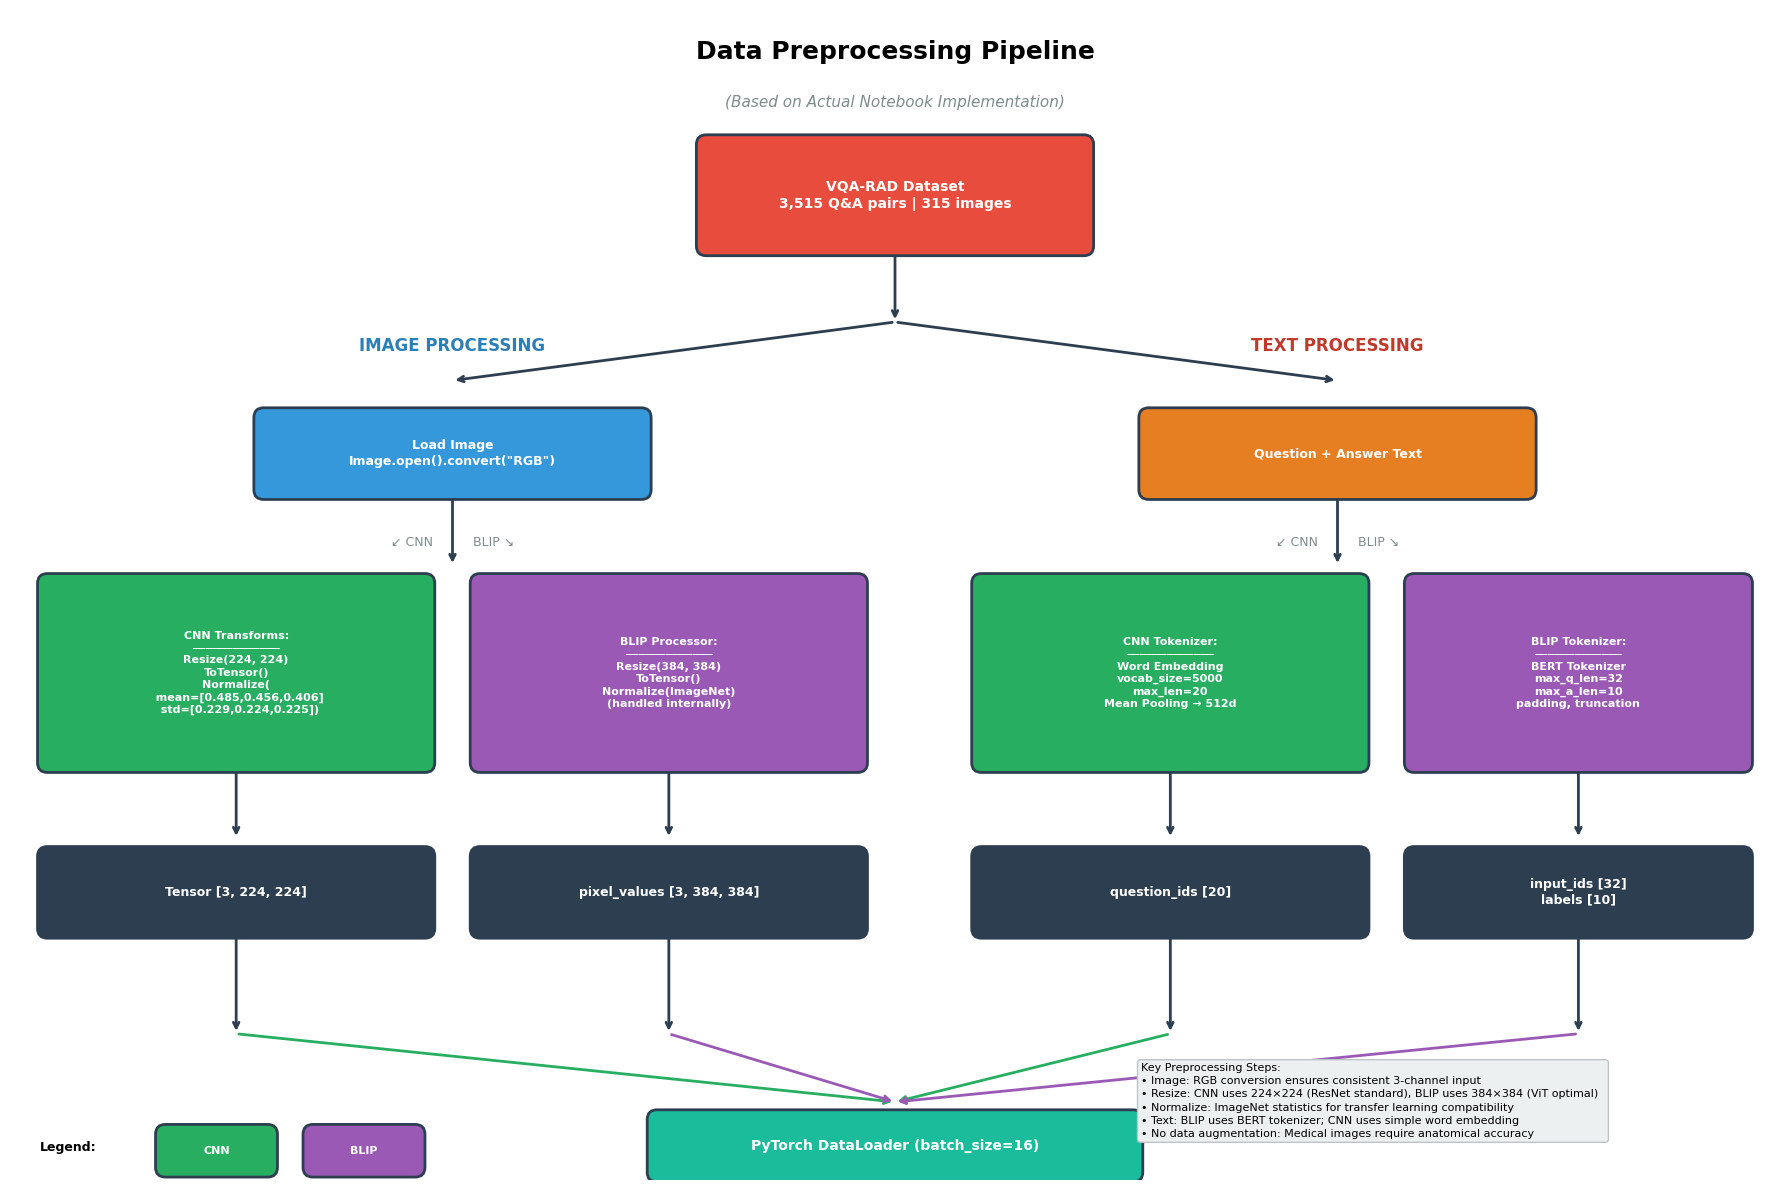


Preprocessing flowchart saved!
  PNG: blip_enhanced_output/ppt_figures/preprocessing_flowchart.png
  PDF: blip_enhanced_output/ppt_figures/preprocessing_flowchart.pdf


In [ ]:
# ==========================================
# Cell 22: Generate Preprocessing Flowchart (Accurate)
# ==========================================
# Based on actual notebook code - simple and direct

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, Rectangle
import numpy as np
import os

# Create output directory
PPT_FIG_DIR = "blip_enhanced_output/ppt_figures"
os.makedirs(PPT_FIG_DIR, exist_ok=True)

fig, ax = plt.subplots(figsize=(18, 12))
ax.set_xlim(0, 18)
ax.set_ylim(0, 12)
ax.axis('off')

def draw_box(x, y, w, h, text, color='#3498db', fontsize=9, text_color='white'):
    box = FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.02,rounding_size=0.1",
                         facecolor=color, edgecolor='#2c3e50', linewidth=2)
    ax.add_patch(box)
    ax.text(x + w/2, y + h/2, text, ha='center', va='center', fontsize=fontsize,
            fontweight='bold', color=text_color, linespacing=1.3)

def draw_arrow(x1, y1, x2, y2, color='#2c3e50'):
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle='->', color=color, lw=2))

# ============ Title ============
ax.text(9, 11.5, 'Data Preprocessing Pipeline', fontsize=18, fontweight='bold', ha='center')
ax.text(9, 11.0, '(Based on Actual Notebook Implementation)', fontsize=11, ha='center', style='italic', color='#7f8c8d')

# ============ Raw Input (Top) ============
draw_box(7, 9.5, 4, 1.2, 'VQA-RAD Dataset\n3,515 Q&A pairs | 315 images', '#e74c3c', fontsize=10)

# ============ Split into Image & Text ============
draw_arrow(9, 9.5, 9, 8.8)
draw_arrow(9, 8.8, 4.5, 8.2)  # to image
draw_arrow(9, 8.8, 13.5, 8.2)  # to text

# ============ IMAGE PIPELINE (Left) ============
ax.text(4.5, 8.5, 'IMAGE PROCESSING', fontsize=12, fontweight='bold', ha='center', color='#2980b9')

# Load Image
draw_box(2.5, 7, 4, 0.9, 'Load Image\nImage.open().convert("RGB")', '#3498db', fontsize=9)
draw_arrow(4.5, 7, 4.5, 6.3)

# CNN vs BLIP split
ax.text(4.5, 6.5, '↙ CNN          BLIP ↘', fontsize=9, ha='center', color='#7f8c8d')

# CNN Image Processing
draw_box(0.3, 4.2, 4, 2, 'CNN Transforms:\n─────────────\nResize(224, 224)\nToTensor()\nNormalize(\n  mean=[0.485,0.456,0.406]\n  std=[0.229,0.224,0.225])', '#27ae60', fontsize=8, text_color='white')

# BLIP Image Processing
draw_box(4.7, 4.2, 4, 2, 'BLIP Processor:\n─────────────\nResize(384, 384)\nToTensor()\nNormalize(ImageNet)\n(handled internally)', '#9b59b6', fontsize=8, text_color='white')

# Output
draw_arrow(2.3, 4.2, 2.3, 3.5)
draw_arrow(6.7, 4.2, 6.7, 3.5)

draw_box(0.3, 2.5, 4, 0.9, 'Tensor [3, 224, 224]', '#2c3e50', fontsize=9)
draw_box(4.7, 2.5, 4, 0.9, 'pixel_values [3, 384, 384]', '#2c3e50', fontsize=9)

# ============ TEXT PIPELINE (Right) ============
ax.text(13.5, 8.5, 'TEXT PROCESSING', fontsize=12, fontweight='bold', ha='center', color='#c0392b')

# Question & Answer
draw_box(11.5, 7, 4, 0.9, 'Question + Answer Text', '#e67e22', fontsize=9)
draw_arrow(13.5, 7, 13.5, 6.3)

ax.text(13.5, 6.5, '↙ CNN          BLIP ↘', fontsize=9, ha='center', color='#7f8c8d')

# CNN Text Processing
draw_box(9.8, 4.2, 4, 2, 'CNN Tokenizer:\n─────────────\nWord Embedding\nvocab_size=5000\nmax_len=20\nMean Pooling → 512d', '#27ae60', fontsize=8, text_color='white')

# BLIP Text Processing
draw_box(14.2, 4.2, 3.5, 2, 'BLIP Tokenizer:\n─────────────\nBERT Tokenizer\nmax_q_len=32\nmax_a_len=10\npadding, truncation', '#9b59b6', fontsize=8, text_color='white')

# Output
draw_arrow(11.8, 4.2, 11.8, 3.5)
draw_arrow(15.95, 4.2, 15.95, 3.5)

draw_box(9.8, 2.5, 4, 0.9, 'question_ids [20]', '#2c3e50', fontsize=9)
draw_box(14.2, 2.5, 3.5, 0.9, 'input_ids [32]\nlabels [10]', '#2c3e50', fontsize=9)

# ============ Final Output ============
draw_arrow(2.3, 2.5, 2.3, 1.5)
draw_arrow(6.7, 2.5, 6.7, 1.5)
draw_arrow(11.8, 2.5, 11.8, 1.5)
draw_arrow(15.95, 2.5, 15.95, 1.5)

# Combine arrows to final
ax.annotate('', xy=(9, 0.8), xytext=(2.3, 1.5), arrowprops=dict(arrowstyle='->', color='#27ae60', lw=2))
ax.annotate('', xy=(9, 0.8), xytext=(6.7, 1.5), arrowprops=dict(arrowstyle='->', color='#9b59b6', lw=2))
ax.annotate('', xy=(9, 0.8), xytext=(11.8, 1.5), arrowprops=dict(arrowstyle='->', color='#27ae60', lw=2))
ax.annotate('', xy=(9, 0.8), xytext=(15.95, 1.5), arrowprops=dict(arrowstyle='->', color='#9b59b6', lw=2))

draw_box(6.5, 0, 5, 0.7, 'PyTorch DataLoader (batch_size=16)', '#1abc9c', fontsize=10)

# ============ Legend ============
ax.text(0.3, 0.3, 'Legend:', fontsize=9, fontweight='bold')
draw_box(1.5, 0.05, 1.2, 0.5, 'CNN', '#27ae60', fontsize=8)
draw_box(3, 0.05, 1.2, 0.5, 'BLIP', '#9b59b6', fontsize=8)

# ============ Key Points Box ============
key_points = """Key Preprocessing Steps:
• Image: RGB conversion ensures consistent 3-channel input
• Resize: CNN uses 224×224 (ResNet standard), BLIP uses 384×384 (ViT optimal)
• Normalize: ImageNet statistics for transfer learning compatibility
• Text: BLIP uses BERT tokenizer; CNN uses simple word embedding
• No data augmentation: Medical images require anatomical accuracy"""

ax.text(11.5, 1.2, key_points, fontsize=8, va='top',
        bbox=dict(boxstyle='round', facecolor='#ecf0f1', edgecolor='#bdc3c7'),
        linespacing=1.4)

plt.tight_layout()
plt.savefig(f'{PPT_FIG_DIR}/preprocessing_flowchart.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.savefig(f'{PPT_FIG_DIR}/preprocessing_flowchart.pdf', bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n{'='*60}")
print("Preprocessing flowchart saved!")
print(f"  PNG: {PPT_FIG_DIR}/preprocessing_flowchart.png")
print(f"  PDF: {PPT_FIG_DIR}/preprocessing_flowchart.pdf")
print('='*60)